In [1]:
import numpy as np
import matplotlib.pyplot as plt
import copy
import yasa
from mne.filter import resample
import pynapple as nap
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import normalize
import requests
from io import BytesIO
import sails
import re
from scipy.stats import entropy

import scipy
from scipy import signal
from scipy.interpolate import griddata
from scipy.signal import correlate
from scipy.stats import pearsonr
from scipy.fft import fft
from scipy.spatial.distance import euclidean
from scipy.signal import spectrogram
from scipy.io import loadmat
import scipy.fft
import scipy.stats
import scipy.io as sio
from scipy.signal import hilbert

import emd as emd
import emd.sift as sift
import emd.spectra as spectra

from neurodsp.sim import sim_combined
from neurodsp.plts import plot_time_series, plot_timefrequency
from neurodsp.utils import create_times
from neurodsp.timefrequency.wavelets import compute_wavelet_transform
from neurodsp.filt import filter_signal

# Load required libraries
from scipy.io import loadmat
from scipy.signal import hilbert
from scipy.interpolate import interp1d
from neurodsp.filt import filter_signal, filter_signal_fir, design_fir_filter
from sklearn.preprocessing import Normalizer
from tqdm import tqdm
import plotly.express as px
import copy
import umap.umap_ as umap
import skdim
from scipy.spatial import cKDTree
import pickle
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as mcolors
import matplotlib.ticker as ticker
from matplotlib.cm import ScalarMappable

## UTILS
from utils import *
from detect_pt import *

from scipy.io import loadmat
from neurodsp.filt import filter_signal
from scipy.spatial import cKDTree

sns.set(style='white', context='notebook')

from spectral_connectivity import Multitaper
from spectral_connectivity import Connectivity
from spectral_connectivity import multitaper_connectivity

General information:
folder 1, OD, post-trial 2

In [2]:
path_to_hpc = r"D:\OS_Basic\Rat_1\CN\post_trial2_2017-09-28_12-21-41\HPC_100_CH46.continuous.mat"
path_to_pfc = r"D:\OS_Basic\Rat_1\CN\post_trial2_2017-09-28_12-21-41\PFC_100_CH11.continuous.mat"
path_to_states = r"D:\OS_Basic\Rat_1\CN\post_trial2_2017-09-28_12-21-41\post_trial2_2017-09-28_12-21-41-statesalysha.mat"

config = emd.sift.SiftConfig.from_yaml_file(r"C:\Users\ejsev\Downloads\sleep scoring\emd_masksift_CA1_config_2500.yml")

In [3]:
def get_data2(lfp_path, state_path):

    data = scipy.io.loadmat(lfp_path)
    states = scipy.io.loadmat(state_path)

    lfp = np.squeeze(data['PFC'])
    hypno = np.squeeze(states['states'])

    fs = extract_frequency_sampling(lfp, hypno)

    unique = np.unique(hypno)
    if unique[0] == 0:
        print('There was 0 in the dataset')
        lfp = lfp[7*fs:-11*fs]
        hypno = hypno[7:-11]
    else:
        None

    return lfp, hypno, fs

There was 0 in the dataset
There was 0 in the dataset


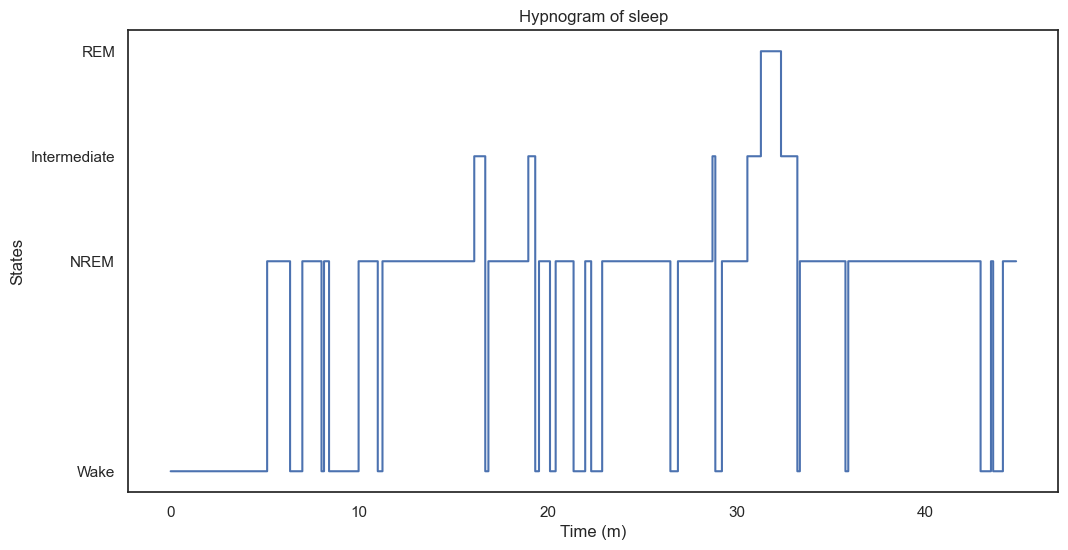

In [4]:
lfpHPC, hypno, fs = get_data(path_to_hpc, path_to_states)
lfpPFC, hypno_pfc, fs = get_data2(path_to_pfc, path_to_states)
plot_hypnogram(hypno)

In [5]:
np.unique(hypno)

array([1, 3, 4, 5], dtype=uint8)

In [10]:
def extract_pt_intervals(lfpHPC, hypno, fs=2500):
    targetFs = 2500
    n_down = fs / targetFs
    start, end = get_start_end(hypno=hypno, sleep_state_id=5)
    rem_interval = nap.IntervalSet(start=start, end=end)
    fs = int(n_down * targetFs)
    t = np.arange(0, len(lfpHPC) / fs, 1 / fs)
    lfp = nap.TsdFrame(t=t, d=lfpHPC, columns=['HPC'])

    # Detect phasic intervals
    lfpHPC_down = preprocess(lfpHPC, n_down)
    phREM = detect_phasic(lfpHPC_down, hypno, targetFs)

    # Create phasic REM IntervalSet
    start, end = [], []
    for rem_idx in phREM:
        for s, e in phREM[rem_idx]:
            start.append(s / targetFs)
            end.append(e / targetFs)
    # Apply a 900 ms duration threshold to phasic intervals
    phasic_interval = nap.IntervalSet(start, end)
    min_duration1 = 0.9  # 900 ms in seconds
    durations1 = phasic_interval['end'] - phasic_interval['start']
    valid_intervals1 = durations1 >= min_duration1
    phasic_interval = nap.IntervalSet(phasic_interval['start'][valid_intervals1], phasic_interval['end'][valid_intervals1])

    # Calculate tonic intervals
    tonic_interval = rem_interval.set_diff(phasic_interval)
    print(f'Number of detected Tonic intervals:{len(tonic_interval)}')
    # Apply a 100 ms duration threshold to tonic intervals
    min_duration = 0.1  # 100 ms in seconds
    durations = tonic_interval['end'] - tonic_interval['start']
    valid_intervals = durations >= min_duration
    tonic_interval = nap.IntervalSet(tonic_interval['start'][valid_intervals], tonic_interval['end'][valid_intervals])
    print(f'Number of detected Tonic intervals after threshold:{len(tonic_interval)}')
    return phasic_interval, tonic_interval, lfp

In [11]:
t = np.arange(0, len(lfpHPC) / fs, 1 / fs)
phasic_interval, tonic_interval, lfp = extract_pt_intervals(lfpHPC, hypno)

len(phasic_interval)

Number of detected Tonic intervals:2
Number of detected Tonic intervals after threshold:2


1

In [15]:
print([phasic_interval])

[  index    start      end
      0  1895.49  1897.76
shape: (1, 2), time unit: sec.]


In [16]:
print([tonic_interval])

[  index    start      end
      0  1879     1895.49
      1  1897.76  1942
shape: (2, 2), time unit: sec.]


In [19]:
interval7 = np.arange(1879.0, 1895.49, 4)
interval8 = np.arange(1897.76, 1942.0, 4)
print(interval7)
print(interval8)

[1879. 1883. 1887. 1891. 1895.]
[1897.76 1901.76 1905.76 1909.76 1913.76 1917.76 1921.76 1925.76 1929.76
 1933.76 1937.76 1941.76]


In [20]:
tonic_time = np.array([
    [1879.00, 1883.00],
    [1883.00, 1887.00],
    [1887.00, 1891.00],
    [1891.00, 1895.49],
    
    [1897.76, 1901.76],
    [1901.76, 1905.76],
    [1905.76, 1909.76],
    [1909.76, 1913.76],
    [1913.76, 1917.76],
    [1917.76, 1921.76],
    [1921.76, 1925.76],
    [1925.76, 1929.76],
    [1929.76, 1933.76],
    [1933.76, 1937.76],
    [1937.76, 1942.00]
])
print(tonic_time.size)

30


In [21]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

In [22]:
for i in range(len(tonic_time)):
    tonic_interval_low = find_nearest(t, tonic_time[i,0])
    tonic_index_low = np.where(t == tonic_interval_low)[0]
    
    tonic_interval_high = find_nearest(t, tonic_time[i,1])
    tonic_index_high = np.where(t == tonic_interval_high)[0]

    signal1 = (lfpHPC[tonic_index_low[0]:tonic_index_high[0]]).T
    print(signal1.size)

10004
10004
10004
11229
10004
10004
10004
10004
10004
10004
10004
10004
10004
10004
10604


In [30]:
highsize = 11229

## Comparison

## Coherence

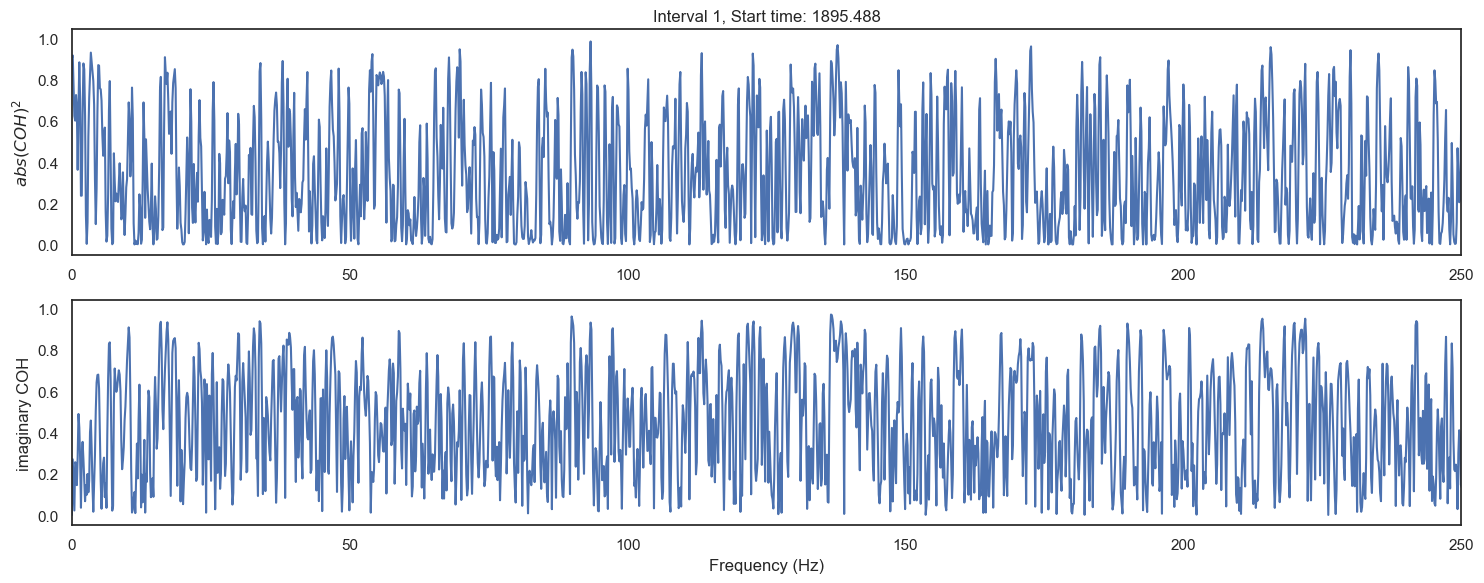

In [31]:
time_halfbandwidth_product = 2 #test value from example
sampling_frequency = 2500
frequency_set = []
coh_set = []
icoh_set = []

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 6), constrained_layout=True)

for i in range(len(phasic_interval)):
    interval_low = find_nearest(t, phasic_interval[i,0])
    index_low = np.where(t == interval_low)[0]
    
    interval_high = find_nearest(t, phasic_interval[i,1])
    index_high = np.where(t == interval_high)[0]

    signal1 = (lfpHPC[index_low[0]:index_high[0]]).T
    signal1_padded = np.pad(signal1, pad_width = (highsize - len(signal1)), mode = 'constant', constant_values = 0)
    signal2 = (lfpPFC[index_low[0]:index_high[0]]).T
    signal2_padded = np.pad(signal2, pad_width = (highsize - len(signal2)), mode = 'constant', constant_values = 0)

    signal_tot = np.vstack((signal1_padded.T,signal2_padded.T)).T
    signal_tot.shape

    time = t[index_low[0]:index_high[0]]
    time_padded = np.pad(time, pad_width = (highsize - len(time)), mode = 'constant', constant_values = 0)

    multitaper = Multitaper(
        signal_tot,
        sampling_frequency=sampling_frequency,
        time_halfbandwidth_product=time_halfbandwidth_product,
        start_time=time_padded[0],
    )
    connectivity = Connectivity.from_multitaper(multitaper)
    
    frequency_set = np.append(frequency_set,connectivity.frequencies)
    coh_set = np.append(coh_set, np.abs((connectivity.coherence_magnitude()[..., 0, 1].squeeze())**2))
    icoh_set = np.append(icoh_set, connectivity.imaginary_coherence()[..., 0, 1].squeeze())
    
    axes[0].plot(
        connectivity.frequencies, np.abs((connectivity.coherence_magnitude()[..., 0, 1].squeeze())**2)
    )
    #axes[0].set_xlim((0, multitaper.nyquist_frequency))
    axes[0].set_xlim((0, 250))
    axes[0].set_title(f"Interval {i+1}, Start time: {phasic_interval[i,0]}")
    #axes[0, i].set_xlabel('Frequency (Hz)')
    axes[0].set_ylabel('$abs(COH)^2$')

    multitaper = Multitaper(
        signal_tot,
        sampling_frequency=sampling_frequency,
        time_halfbandwidth_product=time_halfbandwidth_product,
        start_time=time_padded[0],
    )
    connectivity = Connectivity.from_multitaper(multitaper)
    axes[1].plot(
        connectivity.frequencies, connectivity.imaginary_coherence()[..., 0, 1].squeeze()
    )
    #axes[1].set_xlim((0, multitaper.nyquist_frequency))
    axes[1].set_xlim((0, 250))
    #axes[1].set_title(f"Interval {i+1}")
    axes[1].set_xlabel('Frequency (Hz)')
    axes[1].set_ylabel('imaginary COH')

fig.set_layout_engine(layout='tight')
fig.savefig("phasic_coh_R1T2_CN.png")

mean coh: 0.5766540673438766 +/- 0.0031725576169598646
mean icoh: 0.30604692626273633 +/- 0.0021315669653709977
mean coh: 0.3040948245160748 +/- 0.0026722217920014256
mean icoh: 0.3888143082656575 +/- 0.00296228354491541
mean coh: 0.38701688398861733 +/- 0.003155926833899136
mean icoh: 0.5046688910357143 +/- 0.0029890276020160984
mean coh: 0.34658691880909104 +/- 0.002933257183558483
mean icoh: 0.4624801910508483 +/- 0.0026974272105441165


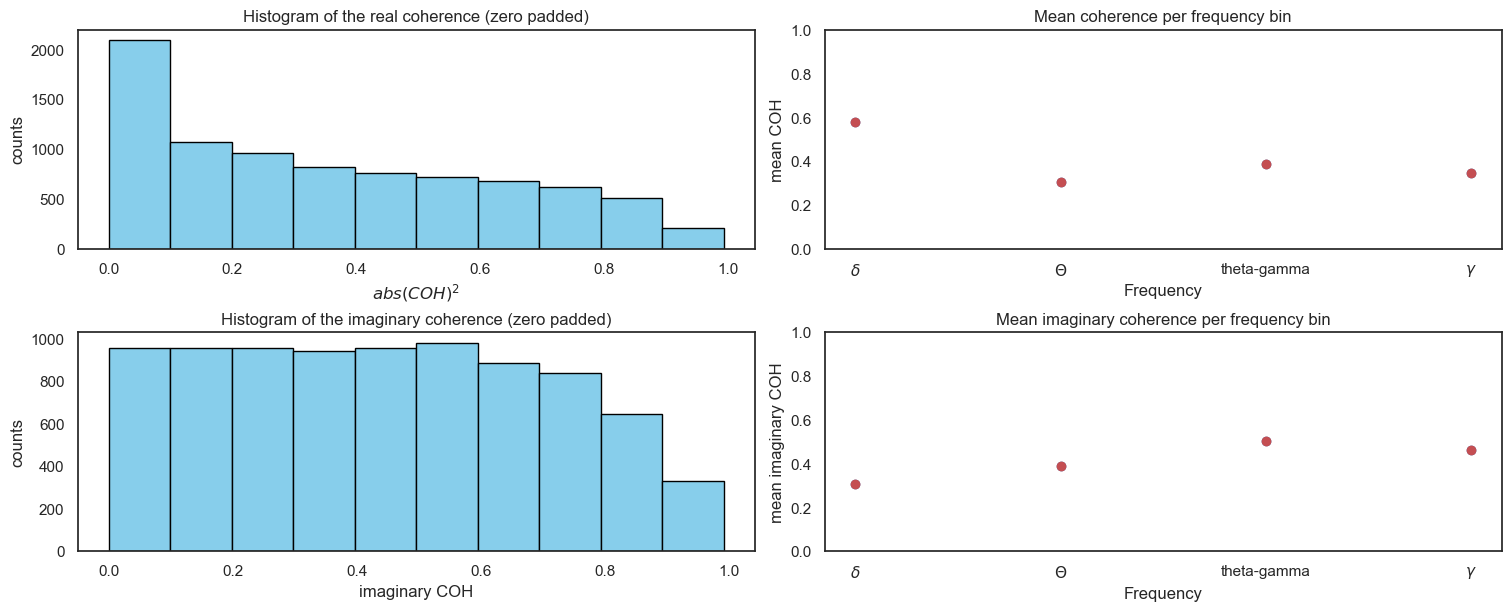

In [32]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 6), constrained_layout=True)

axes[0,0].hist(coh_set, bins=10, color='skyblue', edgecolor='black')
axes[0,0].set_xlabel('$abs(COH)^2$')
axes[0,0].set_ylabel('counts')
axes[0,0].set_title('Histogram of the real coherence (zero padded)')

axes[1,0].hist(icoh_set, bins=10, color='skyblue', edgecolor='black')
axes[1,0].set_xlabel('imaginary COH')
axes[1,0].set_ylabel('counts')
axes[1,0].set_title('Histogram of the imaginary coherence (zero padded)')


mean = binned_statistic(frequency_set, coh_set, bins=[1, 5, 13, 20, 140], statistic='mean')
stdev = binned_statistic(frequency_set, coh_set, bins=[1, 5, 13, 20, 140], statistic='std')
n = len(coh_set)

bin_edges = mean.bin_edges
bin_means = mean.statistic
bin_stdev = stdev.statistic
error = bin_stdev/(np.sqrt(n))

frequency_type = ['$\delta$', '$\Theta$', 'theta-gamma', '$\gamma$']
freq_middle = [3, 8, 16, 80]

axes[0,1].scatter(frequency_type, bin_means)
axes[0,1].errorbar(frequency_type, bin_means, yerr=error, fmt="o", color="r")
axes[0,1].set_ylim(0,1)
#axes[2].set_xlim(0,140)
axes[0,1].set_ylabel('mean COH')
axes[0,1].set_xlabel('Frequency')
axes[0,1].set_title('Mean coherence per frequency bin')

mean2 = binned_statistic(frequency_set, icoh_set, bins=[1, 5, 13, 20, 140], statistic='mean')
stdev2 = binned_statistic(frequency_set, icoh_set, bins=[1, 5, 13, 20, 140], statistic='std')
n2 = len(icoh_set)

bin_edges2 = mean2.bin_edges
bin_means2 = mean2.statistic
bin_stdev2 = stdev2.statistic
error2 = bin_stdev2/(np.sqrt(n2))

axes[1,1].scatter(frequency_type, bin_means2)
axes[1,1].errorbar(frequency_type, bin_means2, yerr=error2, fmt="o", color="r")
axes[1,1].set_ylim(0,1)
#axes[2].set_xlim(0,140)
axes[1,1].set_ylabel('mean imaginary COH')
axes[1,1].set_xlabel('Frequency')
axes[1,1].set_title('Mean imaginary coherence per frequency bin')

#revbinnedstars, edges, _ = binned_statistic(rev_count, stars, 'mean', bins=10)
#revbin = edges[:-1]

for i in range(len(bin_means)):
    print('mean coh:', bin_means[i], '+/-', error[i])
    print('mean icoh:', bin_means2[i], '+/-', error2[i])

mean_coh_phasic = bin_means
mean_icoh_phasic = bin_means2
SEM_coh_phasic = error
SEM_icoh_phasic = error2

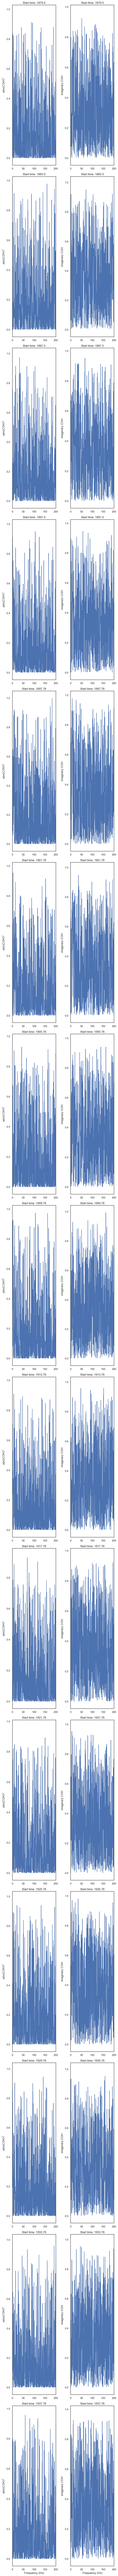

In [33]:
output_folder = "C:/Users/ejsev/Downloads/sleep scoring/outputs/Plots_OS_Basic"
time_halfbandwidth_product = 2 #test value from example
sampling_frequency = 2500
frequency_set = []
coh_set = []
icoh_set = []

fig, axes = plt.subplots(nrows=len(tonic_time), ncols=2, figsize=(7, 150), constrained_layout=True)

for i in range(len(tonic_time)):
    tonic_interval_low = find_nearest(t, tonic_time[i,0])
    tonic_index_low = np.where(t == tonic_interval_low)[0]
    
    tonic_interval_high = find_nearest(t, tonic_time[i,1])
    tonic_index_high = np.where(t == tonic_interval_high)[0]

    signal1 = (lfpHPC[tonic_index_low[0]:tonic_index_high[0]]).T
    signal1_padded = np.pad(signal1, pad_width = (highsize - len(signal1)), mode = 'constant', constant_values = 0)
    signal2 = (lfpPFC[tonic_index_low[0]:tonic_index_high[0]]).T
    signal2_padded = np.pad(signal2, pad_width = (highsize - len(signal2)), mode = 'constant', constant_values = 0)

    signal_tot = np.vstack((signal1_padded.T,signal2_padded.T)).T
    signal_tot.shape

    time = t[index_low[0]:index_high[0]]
    time_padded = np.pad(time, pad_width = (highsize - len(time)), mode = 'constant', constant_values = 0)

    multitaper = Multitaper(
        signal_tot,
        sampling_frequency=sampling_frequency,
        time_halfbandwidth_product=time_halfbandwidth_product,
        start_time=time_padded[0],
    )
    connectivity = Connectivity.from_multitaper(multitaper)
    
    frequency_set = np.append(frequency_set,connectivity.frequencies)
    coh_set = np.append(coh_set, np.abs((connectivity.coherence_magnitude()[..., 0, 1].squeeze())**2))
    
    axes[i, 0].plot(
        connectivity.frequencies, np.abs((connectivity.coherence_magnitude()[..., 0, 1].squeeze())**2)
    )
    #axes[0, i].set_xlim((0, multitaper.nyquist_frequency))
    axes[i, 0].set_xlim((0, 200))
    #axes[i, 0].set_title(f"Interval {i+1}, real COH")
    axes[i,0].set_title(f"Start time: {tonic_time[i,0]}")
    #axes[i, 0].set_xlabel('Frequency (Hz)')
    axes[i, 0].set_ylabel('$abs(COH)^2$')

    multitaper = Multitaper(
        signal_tot,
        sampling_frequency=sampling_frequency,
        time_halfbandwidth_product=time_halfbandwidth_product,
        start_time=time_padded[0],
    )
    connectivity = Connectivity.from_multitaper(multitaper)
    icoh_set = np.append(icoh_set, connectivity.imaginary_coherence()[..., 0, 1].squeeze())
    
    axes[i, 1].plot(
        connectivity.frequencies, connectivity.imaginary_coherence()[..., 0, 1].squeeze()
    )
    #axes[1, i].set_xlim((0, multitaper.nyquist_frequency))
    axes[i, 1].set_xlim((0, 200))
    #axes[i, 1].set_title(f"Interval {i+1}, imaginary COH")
    axes[i,1].set_title(f"Start time: {tonic_time[i,0]}")
    #axes[i, 1].set_xlabel('Frequency (Hz)')
    axes[i, 1].set_ylabel('imaginary COH')

axes[len(tonic_time)-1,0].set_xlabel('Frequency (Hz)')
axes[len(tonic_time)-1,1].set_xlabel('Frequency (Hz)')

fig.set_layout_engine(layout='tight')
fig.savefig("tonic_coh_R1T2_CN.png")

mean coh: 0.2465189054955737 +/- 0.0007965902510772966
mean coh: 0.25691610259340625 +/- 0.0007793996970094456
mean coh: 0.20790722393846772 +/- 0.0007056884315348429
mean coh: 0.18121585285273717 +/- 0.00067839346894905
mean icoh: 0.34720889486289785 +/- 0.0007551860570120695
mean icoh: 0.42665884436337365 +/- 0.0008186244241848867
mean icoh: 0.34278437533664663 +/- 0.0007735885197294828
mean icoh: 0.3502934297511766 +/- 0.000757893348520037


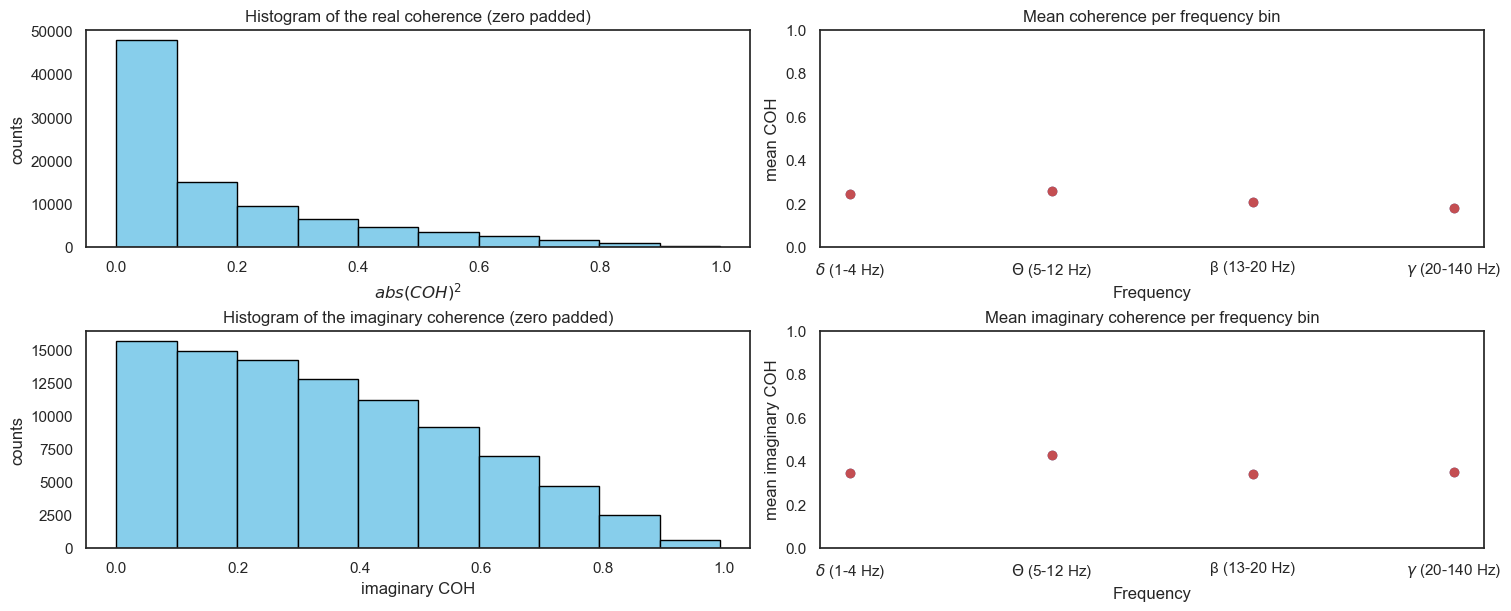

In [34]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 6), constrained_layout=True)

axes[0,0].hist(coh_set, bins=10, color='skyblue', edgecolor='black')
axes[0,0].set_xlabel('$abs(COH)^2$')
axes[0,0].set_ylabel('counts')
axes[0,0].set_title('Histogram of the real coherence (zero padded)')

axes[1,0].hist(icoh_set, bins=10, color='skyblue', edgecolor='black')
axes[1,0].set_xlabel('imaginary COH')
axes[1,0].set_ylabel('counts')
axes[1,0].set_title('Histogram of the imaginary coherence (zero padded)')


mean = binned_statistic(frequency_set, coh_set, bins=[1, 5, 13, 20, 140], statistic='mean')
stdev = binned_statistic(frequency_set, coh_set, bins=[1, 5, 13, 20, 140], statistic='std')
n = len(coh_set)

bin_edges = mean.bin_edges
bin_means = mean.statistic
bin_stdev = stdev.statistic
error = bin_stdev/(np.sqrt(n))

frequency_type = ['$\delta$ (1-4 Hz)', '$\Theta$ (5-12 Hz)', 'β (13-20 Hz)', '$\gamma$ (20-140 Hz)']
freq_middle = [3, 8, 16, 80]

axes[0,1].scatter(frequency_type, bin_means)
axes[0,1].errorbar(frequency_type, bin_means, yerr=error, fmt="o", color="r")
axes[0,1].set_ylim(0,1)
#axes[2].set_xlim(0,140)
axes[0,1].set_ylabel('mean COH')
axes[0,1].set_xlabel('Frequency')
axes[0,1].set_title('Mean coherence per frequency bin')

mean2 = binned_statistic(frequency_set, icoh_set, bins=[1, 5, 13, 20, 140], statistic='mean')
stdev2 = binned_statistic(frequency_set, icoh_set, bins=[1, 5, 13, 20, 140], statistic='std')
n2 = len(icoh_set)

bin_edges2 = mean2.bin_edges
bin_means2 = mean2.statistic
bin_stdev2 = stdev2.statistic
error2 = bin_stdev2/(np.sqrt(n2))

axes[1,1].scatter(frequency_type, bin_means2)
axes[1,1].errorbar(frequency_type, bin_means2, yerr=error2, fmt="o", color="r")
axes[1,1].set_ylim(0,1)
#axes[2].set_xlim(0,140)
axes[1,1].set_ylabel('mean imaginary COH')
axes[1,1].set_xlabel('Frequency')
axes[1,1].set_title('Mean imaginary coherence per frequency bin')

#revbinnedstars, edges, _ = binned_statistic(rev_count, stars, 'mean', bins=10)
#revbin = edges[:-1]

for i in range(len(bin_means)):
    print('mean coh:', bin_means[i], '+/-', error[i])

for i in range(len(bin_means)):
    print('mean icoh:', bin_means2[i], '+/-', error2[i])

mean_coh_tonic = bin_means
mean_icoh_tonic = bin_means2
SEM_coh_tonic = error
SEM_icoh_tonic = error2

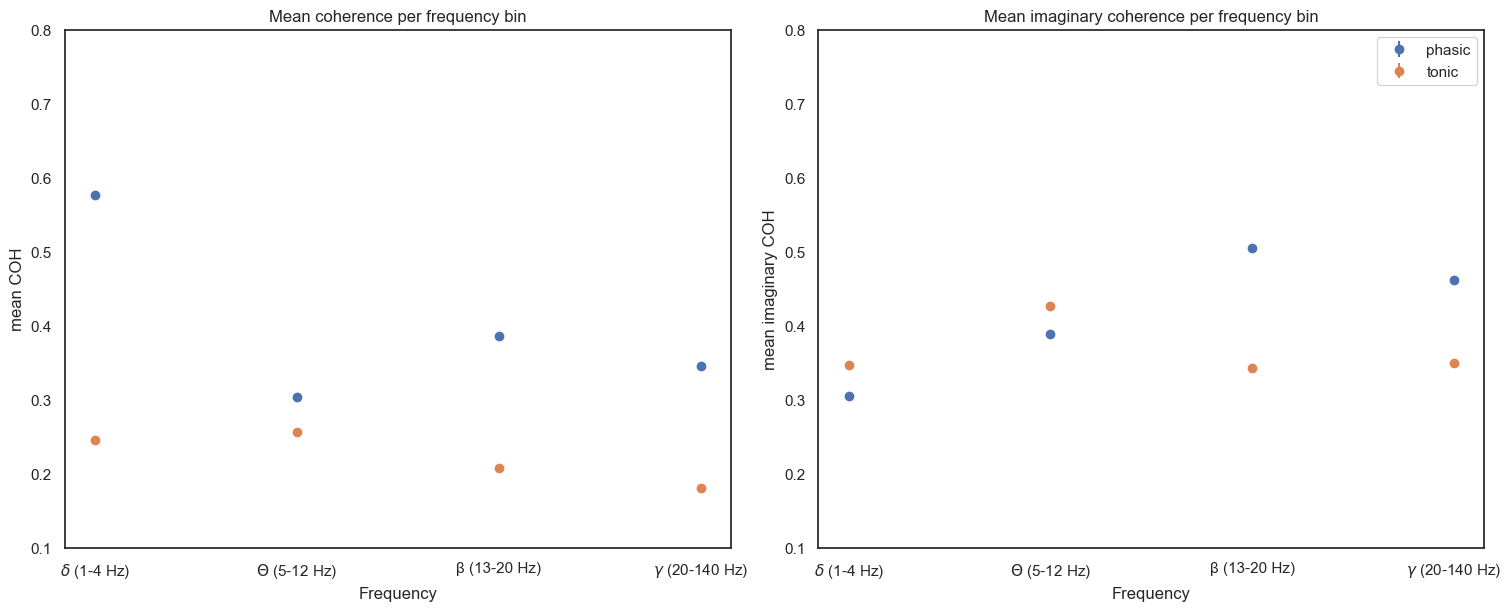

In [35]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6), constrained_layout=True)
axes[0].errorbar(frequency_type, mean_coh_phasic, yerr=SEM_coh_phasic, fmt="o", label='phasic')
axes[0].errorbar(frequency_type, mean_coh_tonic, yerr=SEM_coh_tonic, fmt="o", label='tonic')
axes[0].set_ylim(0.1,0.8)
#axes[2].set_xlim(0,140)
axes[0].set_ylabel('mean COH')
axes[0].set_xlabel('Frequency')
axes[0].set_title('Mean coherence per frequency bin')

axes[1].errorbar(frequency_type, mean_icoh_phasic, yerr=SEM_icoh_phasic, fmt="o", label='phasic')
axes[1].errorbar(frequency_type, mean_icoh_tonic, yerr=SEM_icoh_tonic, fmt="o", label='tonic')
axes[1].set_ylim(0.1,0.8)
#axes[2].set_xlim(0,140)
axes[1].set_ylabel('mean imaginary COH')
axes[1].set_xlabel('Frequency')
axes[1].set_title('Mean imaginary coherence per frequency bin')
plt.legend()

## Phase lag index

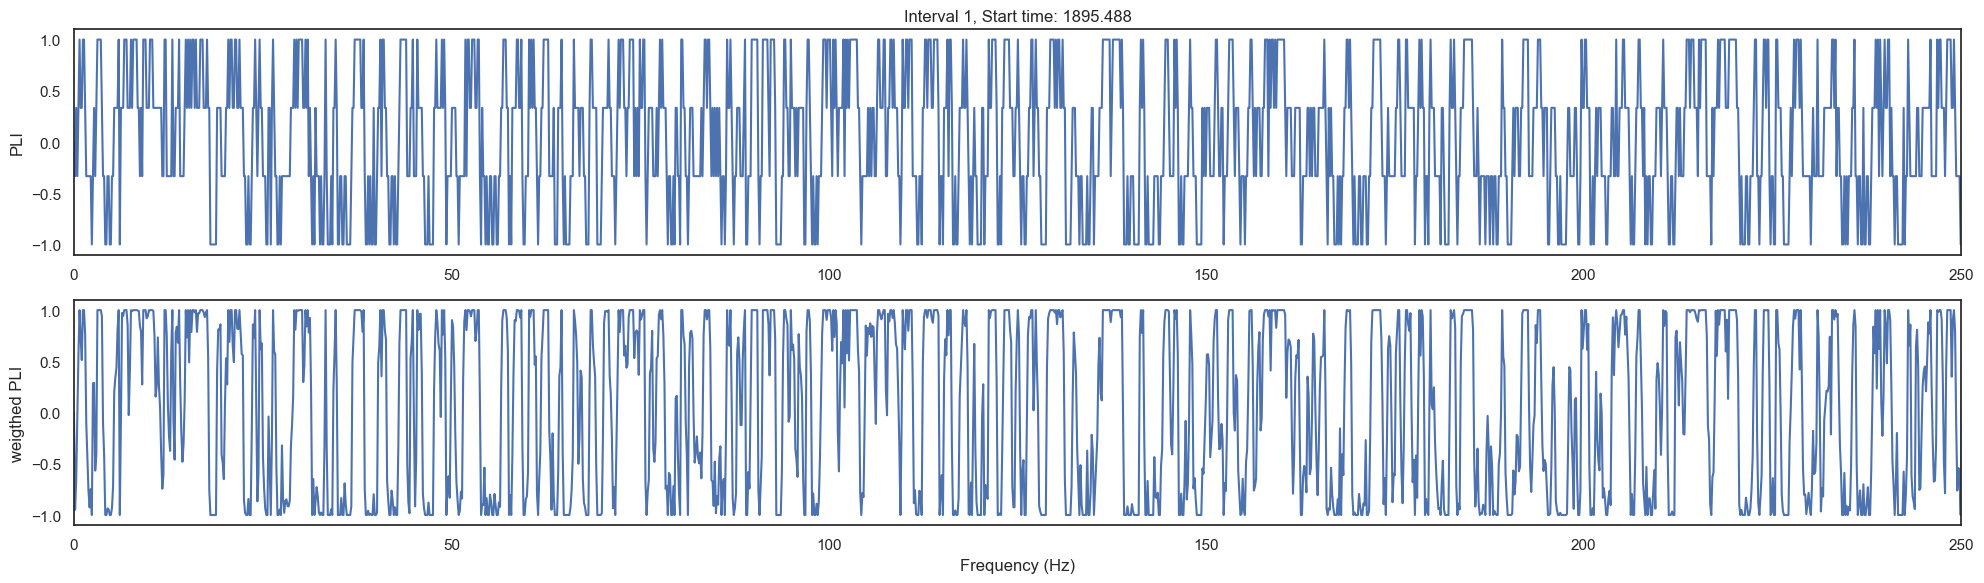

In [36]:
time_halfbandwidth_product = 2 #test value from example
sampling_frequency = 2500
frequency_set = []
pli_set = []
wpli_set = []

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(20, 6), constrained_layout=True)

for i in range(len(phasic_interval)):
    interval_low = find_nearest(t, phasic_interval[i,0])
    index_low = np.where(t == interval_low)[0]
    
    interval_high = find_nearest(t, phasic_interval[i,1])
    index_high = np.where(t == interval_high)[0]

    signal1 = (lfpHPC[index_low[0]:index_high[0]]).T
    signal1_padded = np.pad(signal1, pad_width = (highsize - len(signal1)), mode = 'constant', constant_values = 0)
    signal2 = (lfpPFC[index_low[0]:index_high[0]]).T
    signal2_padded = np.pad(signal2, pad_width = (highsize - len(signal2)), mode = 'constant', constant_values = 0)

    signal_tot = np.vstack((signal1_padded.T,signal2_padded.T)).T
    signal_tot.shape

    time = t[index_low[0]:index_high[0]]
    time_padded = np.pad(time, pad_width = (highsize - len(time)), mode = 'constant', constant_values = 0)

    multitaper = Multitaper(
        signal_tot,
        sampling_frequency=sampling_frequency,
        time_halfbandwidth_product=time_halfbandwidth_product,
        start_time=time_padded[0],
    )
    connectivity = Connectivity.from_multitaper(multitaper)
    
    frequency_set = np.append(frequency_set,connectivity.frequencies)
    pli_set = np.append(pli_set, connectivity.phase_lag_index()[..., 0, 1].squeeze())
    wpli_set = np.append(wpli_set, connectivity.weighted_phase_lag_index()[..., 0, 1].squeeze())
    
    axes[0].plot(
        connectivity.frequencies, connectivity.phase_lag_index()[..., 0, 1].squeeze()
    )
    #axes[0, i].set_xlim((0, multitaper.nyquist_frequency))
    axes[0].set_xlim((0, 250))
    axes[0].set_title(f"Interval {i+1}, Start time: {phasic_interval[i,0]}")
    #axes[0, i].set_xlabel('Frequency (Hz)')
    axes[0].set_ylabel('PLI')

    multitaper = Multitaper(
        signal_tot,
        sampling_frequency=sampling_frequency,
        time_halfbandwidth_product=time_halfbandwidth_product,
        start_time=time_padded[0],
    )
    connectivity = Connectivity.from_multitaper(multitaper)
    axes[1].plot(
        connectivity.frequencies, connectivity.weighted_phase_lag_index()[..., 0, 1].squeeze(),
    )
    #axes[1, i].set_xlim((0, multitaper.nyquist_frequency))
    axes[1].set_xlim((0, 250))
    #axes[1, i].set_title(f"Interval {i+1}")
    axes[1].set_xlabel('Frequency (Hz)')
    axes[1].set_ylabel('weigthed PLI')

fig.set_layout_engine(layout='tight')
fig.savefig("phasic_pli_R1T2_CN.png")

mean pli: -0.037037037037037056 +/- 0.007478176249319921
mean pli: 0.3827160493827161 +/- 0.005560925806261188
mean pli: 0.20567375886524833 +/- 0.00696412562626175
mean pli: 0.06206329634196469 +/- 0.007532948924982368
mean wpli: -0.09519724757014734 +/- 0.008718503701205435
mean wpli: 0.5404470902945864 +/- 0.0064365985404597325
mean wpli: 0.35964978574267437 +/- 0.008080978230017546
mean wpli: 0.07410682745520715 +/- 0.009025862670269153


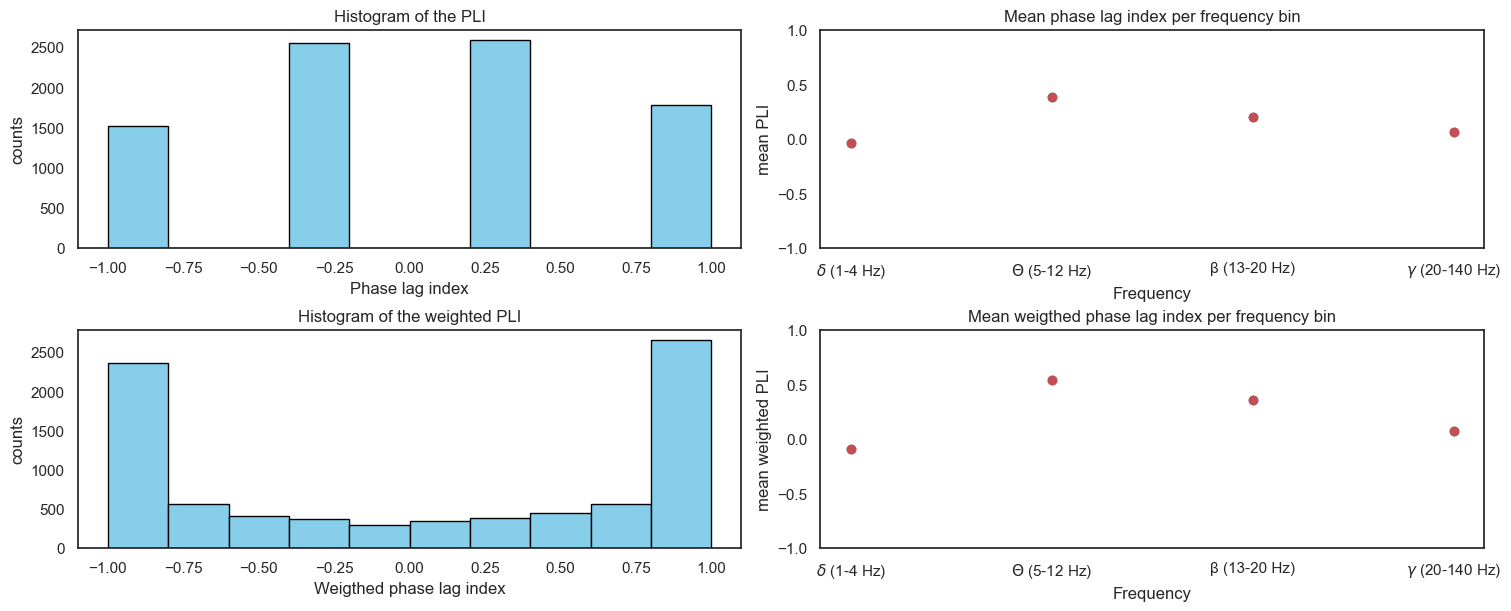

In [37]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 6), constrained_layout=True)

axes[0,0].hist(pli_set, bins=10, color='skyblue', edgecolor='black')
axes[0,0].set_xlabel('Phase lag index')
axes[0,0].set_ylabel('counts')
axes[0,0].set_title('Histogram of the PLI')

axes[1,0].hist(wpli_set, bins=10, color='skyblue', edgecolor='black')
axes[1,0].set_xlabel('Weigthed phase lag index')
axes[1,0].set_ylabel('counts')
axes[1,0].set_title('Histogram of the weighted PLI')

mean = binned_statistic(frequency_set, (pli_set), bins=[1, 5, 13, 20, 140], statistic='mean')
stdev = binned_statistic(frequency_set, (pli_set), bins=[1, 5, 13, 20, 140], statistic='std')
n = len(pli_set)

bin_edges = mean.bin_edges
bin_means = mean.statistic
bin_stdev = stdev.statistic
error = bin_stdev/(np.sqrt(n))

frequency_type = ['$\delta$ (1-4 Hz)', '$\Theta$ (5-12 Hz)', 'β (13-20 Hz)', '$\gamma$ (20-140 Hz)']
freq_middle = [3, 8, 16, 80]

axes[0,1].scatter(frequency_type, bin_means)
axes[0,1].errorbar(frequency_type, bin_means, yerr=error, fmt="o", color="r")
axes[0,1].set_ylim(-1,1)
#axes[2].set_xlim(0,140)
axes[0,1].set_ylabel('mean PLI')
axes[0,1].set_xlabel('Frequency')
axes[0,1].set_title('Mean phase lag index per frequency bin')

mean2 = binned_statistic(frequency_set, (wpli_set), bins=[1, 5, 13, 20, 140], statistic='mean')
stdev2 = binned_statistic(frequency_set, (wpli_set), bins=[1, 5, 13, 20, 140], statistic='std')

bin_edges2 = mean2.bin_edges
bin_means2 = mean2.statistic
bin_stdev2 = stdev2.statistic
error2 = bin_stdev2/(np.sqrt(n))

axes[1,1].scatter(frequency_type, bin_means2)
axes[1,1].errorbar(frequency_type, bin_means2, yerr=error2, fmt="o", color="r")
axes[1,1].set_ylim(-1,1)
#axes[2].set_xlim(0,140)
axes[1,1].set_ylabel('mean weighted PLI')
axes[1,1].set_xlabel('Frequency')
axes[1,1].set_title('Mean weigthed phase lag index per frequency bin')

for i in range(len(bin_means)):
    print('mean pli:', bin_means[i], '+/-', error[i])

for i in range(len(bin_means)):
    print('mean wpli:', bin_means2[i], '+/-', error2[i])
#revbinnedstars, edges, _ = binned_statistic(rev_count, stars, 'mean', bins=10)
#revbin = edges[:-1]

mean_pli_phasic = bin_means
mean_wpli_phasic = bin_means2
SEM_pli_phasic = error
SEM_wpli_phasic = error2

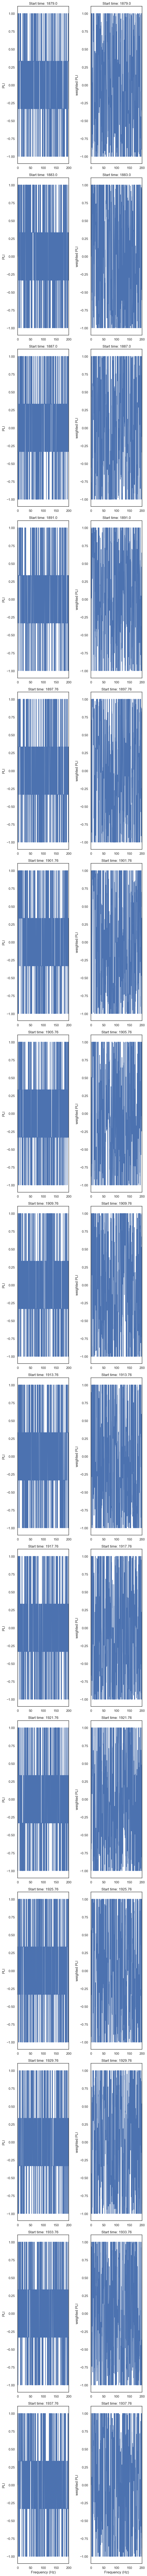

In [38]:
output_folder = "C:/Users/ejsev/Downloads/sleep scoring/outputs/Plots_OS_Basic"
time_halfbandwidth_product = 2 #test value from example
sampling_frequency = 2500
frequency_set = []
pli_set = []
wpli_set = []

fig, axes = plt.subplots(nrows=len(tonic_time), ncols=2, figsize=(7,120), constrained_layout=True)

for i in range(len(tonic_time)):
    tonic_interval_low = find_nearest(t, tonic_time[i,0])
    tonic_index_low = np.where(t == tonic_interval_low)[0]
    
    tonic_interval_high = find_nearest(t, tonic_time[i,1])
    tonic_index_high = np.where(t == tonic_interval_high)[0]

    signal1 = (lfpHPC[tonic_index_low[0]:tonic_index_high[0]]).T
    signal1_padded = np.pad(signal1, pad_width = (highsize - len(signal1)), mode = 'constant', constant_values = 0)
    signal2 = (lfpPFC[tonic_index_low[0]:tonic_index_high[0]]).T
    signal2_padded = np.pad(signal2, pad_width = (highsize - len(signal2)), mode = 'constant', constant_values = 0)

    signal_tot = np.vstack((signal1_padded.T,signal2_padded.T)).T
    signal_tot.shape

    time = t[index_low[0]:index_high[0]]
    time_padded = np.pad(time, pad_width = (highsize - len(time)), mode = 'constant', constant_values = 0)

    multitaper = Multitaper(
        signal_tot,
        sampling_frequency=sampling_frequency,
        time_halfbandwidth_product=time_halfbandwidth_product,
        start_time=time_padded[0],
    )
    connectivity = Connectivity.from_multitaper(multitaper)
    
    frequency_set = np.append(frequency_set,connectivity.frequencies)
    pli_set = np.append(pli_set, connectivity.phase_lag_index()[..., 0, 1].squeeze())
    
    axes[i, 0].plot(
        connectivity.frequencies, connectivity.phase_lag_index()[..., 0, 1].squeeze()
    )
    #axes[0, i].set_xlim((0, multitaper.nyquist_frequency))
    axes[i, 0].set_xlim((0, 200))
    #axes[i, 0].set_title(f"Interval {i+1}, real COH")
    axes[i, 0].set_title(f"Start time: {tonic_time[i,0]}")
    #axes[i, 0].set_xlabel('Frequency (Hz)')
    axes[i, 0].set_ylabel('PLI')

    multitaper = Multitaper(
        signal_tot,
        sampling_frequency=sampling_frequency,
        time_halfbandwidth_product=time_halfbandwidth_product,
        start_time=time_padded[0],
    )
    connectivity = Connectivity.from_multitaper(multitaper)
    wpli_set = np.append(wpli_set, connectivity.weighted_phase_lag_index()[..., 0, 1].squeeze())
    axes[i, 1].plot(
        connectivity.frequencies, connectivity.weighted_phase_lag_index()[..., 0, 1].squeeze()
    )
    #axes[1, i].set_xlim((0, multitaper.nyquist_frequency))
    axes[i, 1].set_xlim((0, 200))
    #axes[i, 1].set_title(f"Interval {i+1}, imaginary COH")
    axes[i, 1].set_title(f"Start time: {tonic_time[i,0]}")
    #axes[i, 1].set_xlabel('Frequency (Hz)')
    axes[i, 1].set_ylabel('weighted PLI')

axes[len(tonic_time)-1,0].set_xlabel('Frequency (Hz)')
axes[len(tonic_time)-1,1].set_xlabel('Frequency (Hz)')

fig.set_layout_engine(layout='tight')
fig.savefig("tonic_pli_R1T2_CN.png")

mean pli: 0.05050505050505045 +/- 0.0019687006298993517
mean pli: 0.26722689075630274 +/- 0.0019507430759067672
mean pli: 0.025048169556840034 +/- 0.0019276914242766477
mean pli: -0.011010338521255497 +/- 0.001923399721727042
mean wpli: 0.07866738840155135 +/- 0.002382443647299827
mean wpli: 0.3686128015247541 +/- 0.002303115815769981
mean wpli: 0.020674050344284968 +/- 0.0023381098988395042
mean wpli: -0.020987859470901368 +/- 0.0023511565346310205


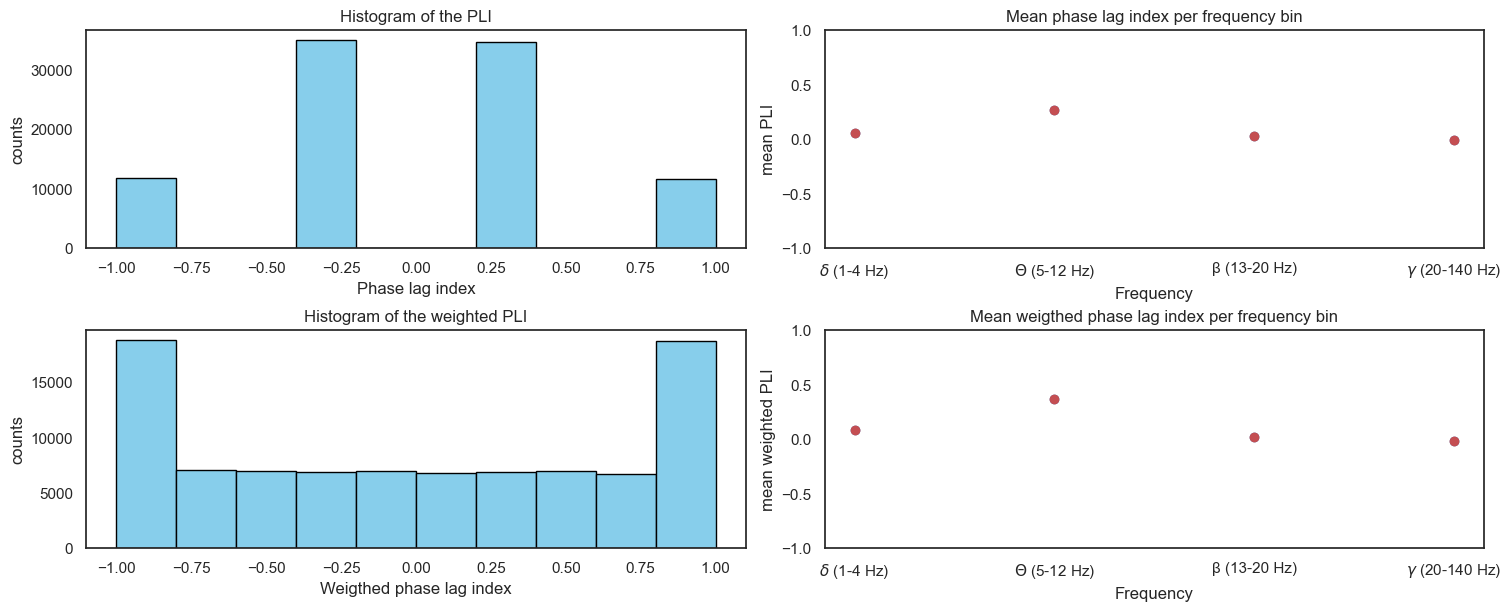

In [39]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 6), constrained_layout=True)

axes[0,0].hist(pli_set, bins=10, color='skyblue', edgecolor='black')
axes[0,0].set_xlabel('Phase lag index')
axes[0,0].set_ylabel('counts')
axes[0,0].set_title('Histogram of the PLI')

axes[1,0].hist(wpli_set, bins=10, color='skyblue', edgecolor='black')
axes[1,0].set_xlabel('Weigthed phase lag index')
axes[1,0].set_ylabel('counts')
axes[1,0].set_title('Histogram of the weighted PLI')

mean = binned_statistic(frequency_set, (pli_set), bins=[1, 5, 13, 20, 140], statistic='mean')
stdev = binned_statistic(frequency_set, (pli_set), bins=[1, 5, 13, 20, 140], statistic='std')
n = len(pli_set)

bin_edges = mean.bin_edges
bin_means = mean.statistic
bin_stdev = stdev.statistic
error = bin_stdev/(np.sqrt(n))

freq_middle = [3, 8, 16, 80]

axes[0,1].scatter(frequency_type, bin_means)
axes[0,1].errorbar(frequency_type, bin_means, yerr=error, fmt="o", color="r")
axes[0,1].set_ylim(-1,1)
#axes[2].set_xlim(0,140)
axes[0,1].set_ylabel('mean PLI')
axes[0,1].set_xlabel('Frequency')
axes[0,1].set_title('Mean phase lag index per frequency bin')

mean2 = binned_statistic(frequency_set, (wpli_set), bins=[1, 5, 13, 20, 140], statistic='mean')
stdev2 = binned_statistic(frequency_set, (wpli_set), bins=[1, 5, 13, 20, 140], statistic='std')

bin_edges2 = mean2.bin_edges
bin_means2 = mean2.statistic
bin_stdev2 = stdev2.statistic
error2 = bin_stdev2/(np.sqrt(n))

axes[1,1].scatter(frequency_type, bin_means2)
axes[1,1].errorbar(frequency_type, bin_means2, yerr=error2, fmt="o", color="r")
axes[1,1].set_ylim(-1,1)
#axes[2].set_xlim(0,140)
axes[1,1].set_ylabel('mean weighted PLI')
axes[1,1].set_xlabel('Frequency')
axes[1,1].set_title('Mean weigthed phase lag index per frequency bin')

for i in range(len(bin_means)):
    print('mean pli:', bin_means[i], '+/-', error[i])

for i in range(len(bin_means)):
    print('mean wpli:', bin_means2[i], '+/-', error2[i])
#revbinnedstars, edges, _ = binned_statistic(rev_count, stars, 'mean', bins=10)
#revbin = edges[:-1]
mean_pli_tonic = bin_means
mean_wpli_tonic = bin_means2
SEM_pli_tonic = error
SEM_wpli_tonic = error2

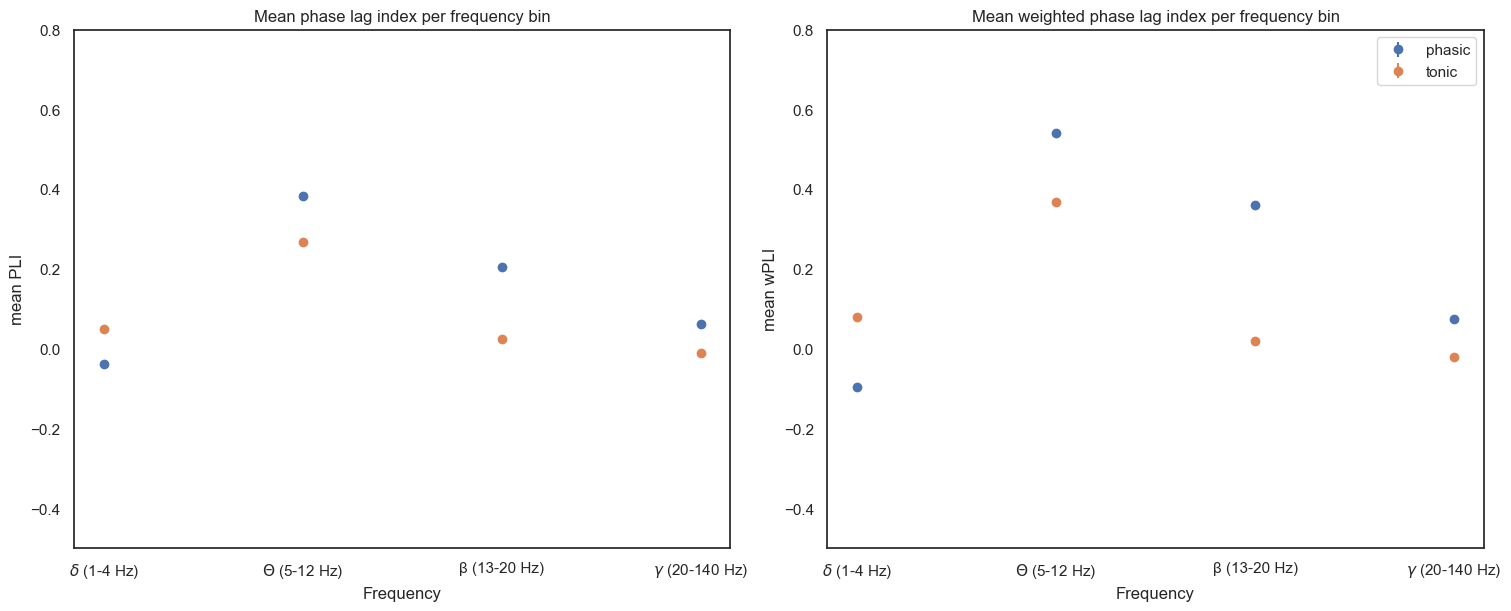

In [40]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6), constrained_layout=True)
axes[0].errorbar(frequency_type, mean_pli_phasic, yerr=SEM_pli_phasic, fmt="o", label='phasic')
axes[0].errorbar(frequency_type, mean_pli_tonic, yerr=SEM_pli_tonic, fmt="o", label='tonic')
axes[0].set_ylim(-0.5,0.8)
#axes[2].set_xlim(0,140)
axes[0].set_ylabel('mean PLI')
axes[0].set_xlabel('Frequency')
axes[0].set_title('Mean phase lag index per frequency bin')

axes[1].errorbar(frequency_type, mean_wpli_phasic, yerr=SEM_wpli_phasic, fmt="o", label='phasic')
axes[1].errorbar(frequency_type, mean_wpli_tonic, yerr=SEM_wpli_tonic, fmt="o", label='tonic')
axes[1].set_ylim(-0.5,0.8)
#axes[2].set_xlim(0,140)
axes[1].set_ylabel('mean wPLI')
axes[1].set_xlabel('Frequency')
axes[1].set_title('Mean weighted phase lag index per frequency bin')
plt.legend()

## Debiased squared PLI

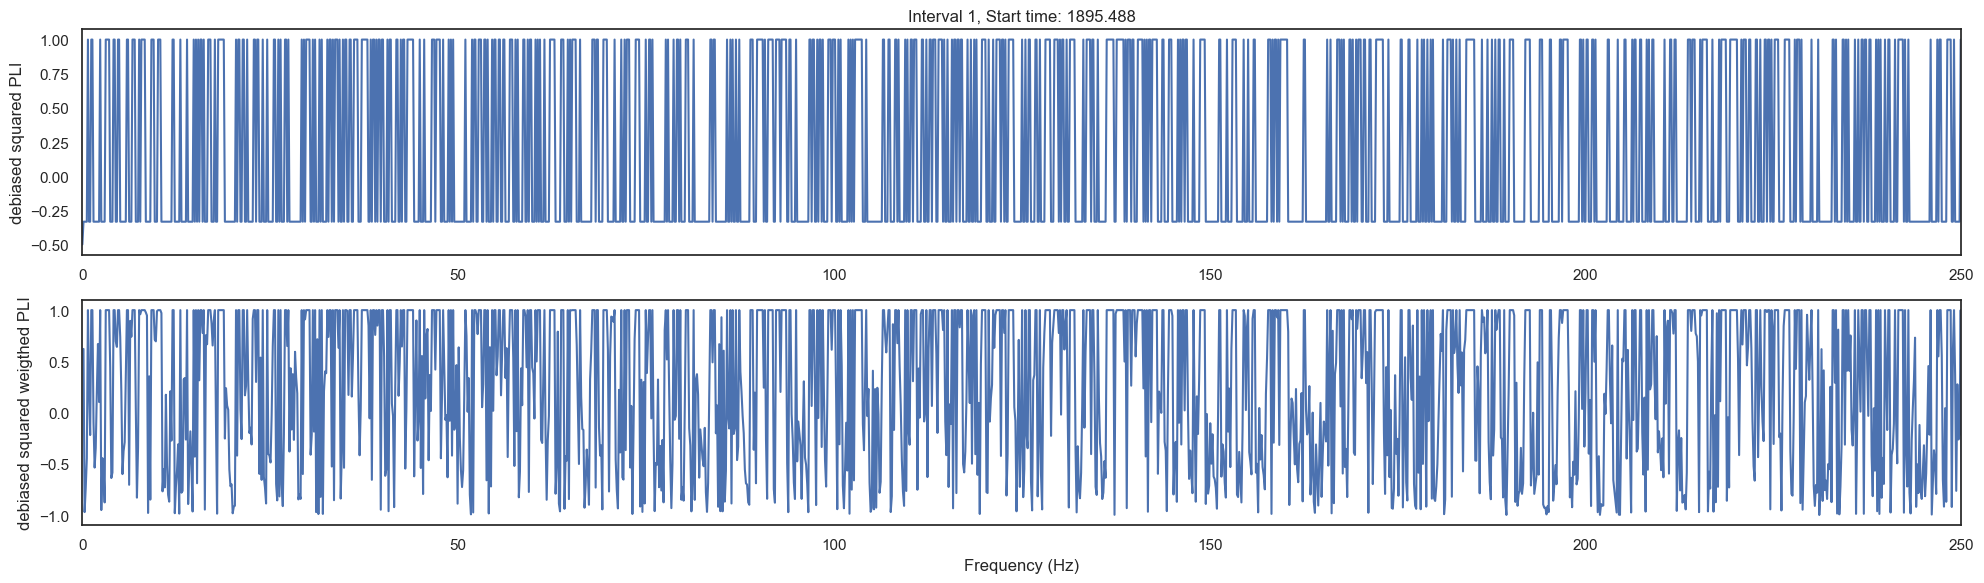

In [41]:
time_halfbandwidth_product = 2 #test value from example
sampling_frequency = 2500
frequency_set = []
dspli_set = []
wdspli_set = []

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(20, 6), constrained_layout=True)

for i in range(len(phasic_interval)):
    interval_low = find_nearest(t, phasic_interval[i,0])
    index_low = np.where(t == interval_low)[0]
    
    interval_high = find_nearest(t, phasic_interval[i,1])
    index_high = np.where(t == interval_high)[0]

    signal1 = (lfpHPC[index_low[0]:index_high[0]]).T
    signal1_padded = np.pad(signal1, pad_width = (highsize - len(signal1)), mode = 'constant', constant_values = 0)
    signal2 = (lfpPFC[index_low[0]:index_high[0]]).T
    signal2_padded = np.pad(signal2, pad_width = (highsize - len(signal2)), mode = 'constant', constant_values = 0)

    signal_tot = np.vstack((signal1_padded.T,signal2_padded.T)).T
    signal_tot.shape

    time = t[index_low[0]:index_high[0]]
    time_padded = np.pad(time, pad_width = (highsize - len(time)), mode = 'constant', constant_values = 0)

    multitaper = Multitaper(
        signal_tot,
        sampling_frequency=sampling_frequency,
        time_halfbandwidth_product=time_halfbandwidth_product,
        start_time=time_padded[0],
    )
    connectivity = Connectivity.from_multitaper(multitaper)
    
    frequency_set = np.append(frequency_set,connectivity.frequencies)
    dspli_set = np.append(dspli_set, connectivity.debiased_squared_phase_lag_index()[..., 0, 1].squeeze())
    wdspli_set = np.append(wdspli_set, connectivity.debiased_squared_weighted_phase_lag_index()[..., 0, 1].squeeze())
    
    axes[0].plot(
        connectivity.frequencies, connectivity.debiased_squared_phase_lag_index()[..., 0, 1].squeeze(),
    )
    #axes[0, i].set_xlim((0, multitaper.nyquist_frequency))
    axes[0].set_xlim((0, 250))
    axes[0].set_title(f"Interval {i+1}, Start time: {phasic_interval[i,0]}")
    #axes[0, i].set_xlabel('Frequency (Hz)')
    axes[0].set_ylabel('debiased squared PLI')

    multitaper = Multitaper(
        signal_tot,
        sampling_frequency=sampling_frequency,
        time_halfbandwidth_product=time_halfbandwidth_product,
        start_time=time_padded[0],
    )
    connectivity = Connectivity.from_multitaper(multitaper)
    axes[1].plot(
        connectivity.frequencies, connectivity.debiased_squared_weighted_phase_lag_index()[..., 0, 1].squeeze(),
    )
    #axes[1, i].set_xlim((0, multitaper.nyquist_frequency))
    axes[1].set_xlim((0, 250))
    #axes[1, i].set_title(f"Interval {i+1}")
    axes[1].set_xlabel('Frequency (Hz)')
    axes[1].set_ylabel('debiased squared weigthed PLI')

fig.set_layout_engine(layout='tight')
fig.savefig("phasic_dspli_R1T2_CN.png")

mean dspli: 0.20987654320987648 +/- 0.007132003470472188
mean dspli: 0.11111111111111117 +/- 0.00684246712029917
mean dspli: 0.17730496453900704 +/- 0.007055964216423202
mean dspli: 0.22400328812166057 +/- 0.007159273772878127
mean wdspli: 0.3167486243276298 +/- 0.0076236395462253035
mean wdspli: 0.2759270890843099 +/- 0.00830789953670064
mean wdspli: 0.290597050315301 +/- 0.008018806519232861
mean wdspli: 0.313056640014464 +/- 0.007907749647654236


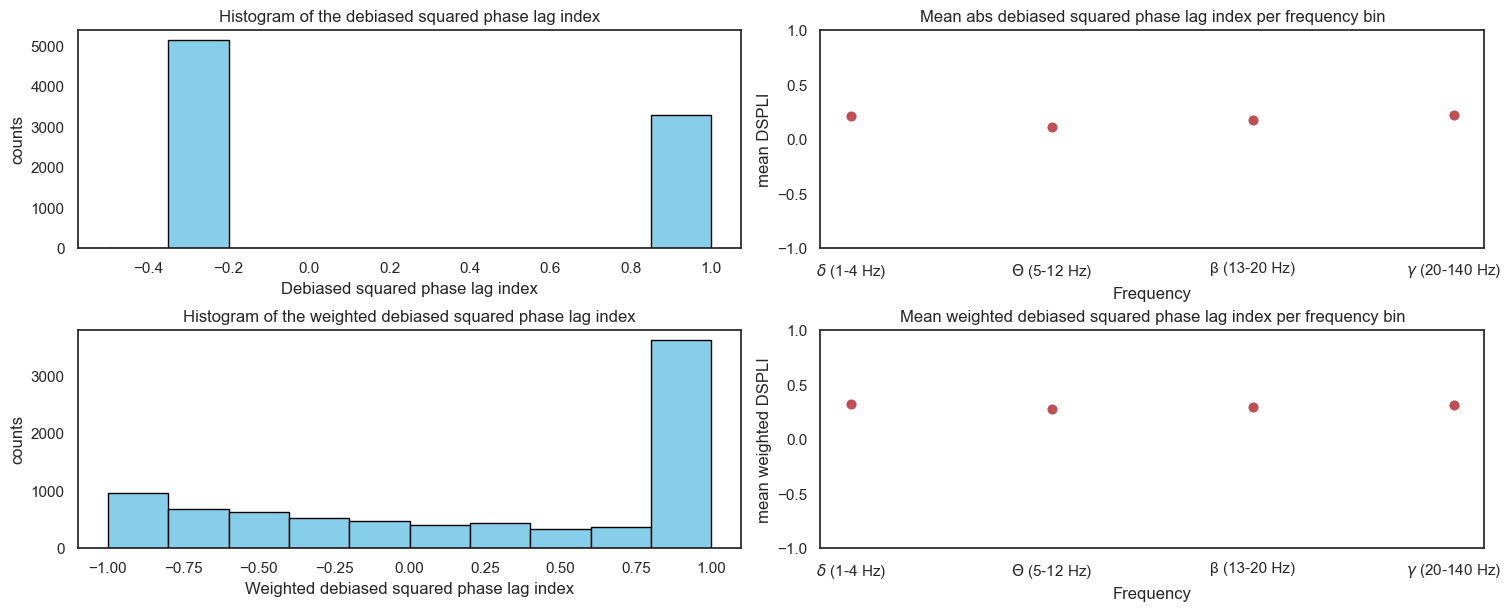

In [42]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 6), constrained_layout=True)

axes[0,0].hist(dspli_set, bins=10, color='skyblue', edgecolor='black')
axes[0,0].set_xlabel('Debiased squared phase lag index')
axes[0,0].set_ylabel('counts')
axes[0,0].set_title('Histogram of the debiased squared phase lag index')

axes[1,0].hist(wdspli_set, bins=10, color='skyblue', edgecolor='black')
axes[1,0].set_xlabel('Weighted debiased squared phase lag index')
axes[1,0].set_ylabel('counts')
axes[1,0].set_title('Histogram of the weighted debiased squared phase lag index')

mean = binned_statistic(frequency_set, dspli_set, bins=[1, 5, 13, 20, 140], statistic='mean')
stdev = binned_statistic(frequency_set, dspli_set, bins=[1, 5, 13, 20, 140], statistic='std')
n = len(dspli_set)

bin_edges = mean.bin_edges
bin_means = mean.statistic
bin_stdev = stdev.statistic
error = bin_stdev/(np.sqrt(n))

freq_middle = [3, 8, 16, 80]

axes[0,1].scatter(frequency_type, bin_means)
axes[0,1].errorbar(frequency_type, bin_means, yerr=error, fmt="o", color="r")
axes[0,1].set_ylim(-1,1)
#axes[2].set_xlim(0,140)
axes[0,1].set_ylabel('mean DSPLI')
axes[0,1].set_xlabel('Frequency')
axes[0,1].set_title('Mean abs debiased squared phase lag index per frequency bin')

mean2 = binned_statistic(frequency_set, wdspli_set, bins=[1, 5, 13, 20, 140], statistic='mean')
stdev2 = binned_statistic(frequency_set, wdspli_set, bins=[1, 5, 13, 20, 140], statistic='std')

bin_edges2 = mean2.bin_edges
bin_means2 = mean2.statistic
bin_stdev2 = stdev2.statistic
error2 = bin_stdev2/(np.sqrt(n))

axes[1,1].scatter(frequency_type, bin_means2)
axes[1,1].errorbar(frequency_type, bin_means2, yerr=error2, fmt="o", color="r")
axes[1,1].set_ylim(-1,1)
#axes[2].set_xlim(0,140)
axes[1,1].set_ylabel('mean weighted DSPLI')
axes[1,1].set_xlabel('Frequency')
axes[1,1].set_title('Mean weighted debiased squared phase lag index per frequency bin')

for i in range(len(bin_means)):
    print('mean dspli:', bin_means[i], '+/-', error[i])

for i in range(len(bin_means)):
    print('mean wdspli:', bin_means2[i], '+/-', error2[i])
#revbinnedstars, edges, _ = binned_statistic(rev_count, stars, 'mean', bins=10)
#revbin = edges[:-1]

mean_dspli_phasic = bin_means
mean_wdspli_phasic = bin_means2
SEM_dspli_phasic = error
SEM_wdspli_phasic = error2

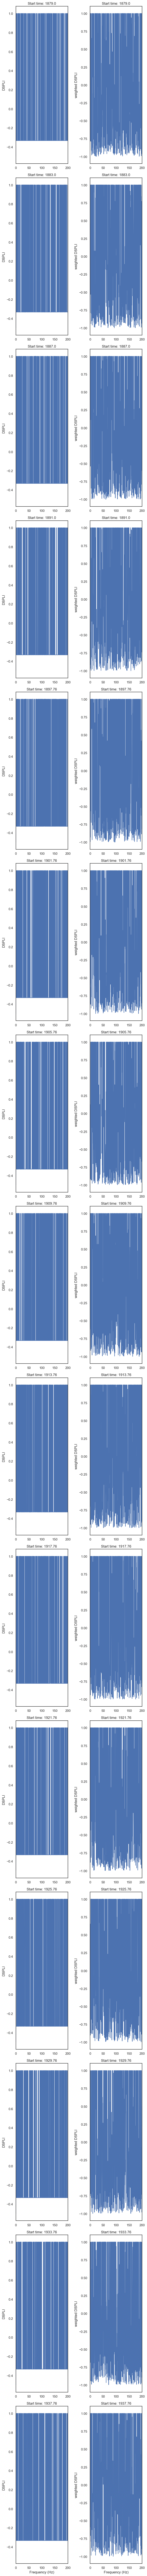

In [43]:
output_folder = "C:/Users/ejsev/Downloads/sleep scoring/outputs/Plots_OS_Basic"
time_halfbandwidth_product = 2 #test value from example
sampling_frequency = 2500
frequency_set = []
frequency_set2 = []
dspli_set = []
wdspli_set = []

fig, axes = plt.subplots(nrows=len(tonic_time), ncols=2, figsize=(7, 120), constrained_layout=True)

for i in range(len(tonic_time)):
    tonic_interval_low = find_nearest(t, tonic_time[i,0])
    tonic_index_low = np.where(t == tonic_interval_low)[0]
    
    tonic_interval_high = find_nearest(t, tonic_time[i,1])
    tonic_index_high = np.where(t == tonic_interval_high)[0]

    signal1 = (lfpHPC[tonic_index_low[0]:tonic_index_high[0]]).T
    signal1_padded = np.pad(signal1, pad_width = (highsize - len(signal1)), mode = 'constant', constant_values = 0)
    signal2 = (lfpPFC[tonic_index_low[0]:tonic_index_high[0]]).T
    signal2_padded = np.pad(signal2, pad_width = (highsize - len(signal2)), mode = 'constant', constant_values = 0)

    signal_tot = np.vstack((signal1_padded.T,signal2_padded.T)).T
    signal_tot.shape

    time = t[index_low[0]:index_high[0]]
    time_padded = np.pad(time, pad_width = (highsize - len(time)), mode = 'constant', constant_values = 0)

    multitaper = Multitaper(
        signal_tot,
        sampling_frequency=sampling_frequency,
        time_halfbandwidth_product=time_halfbandwidth_product,
        start_time=time_padded[0],
    )
    connectivity = Connectivity.from_multitaper(multitaper)
    
    frequency_set = np.append(frequency_set,connectivity.frequencies)
    dspli_set = np.append(dspli_set, connectivity.debiased_squared_phase_lag_index()[..., 0, 1].squeeze())
    
    axes[i, 0].plot(
        connectivity.frequencies, connectivity.debiased_squared_phase_lag_index()[..., 0, 1].squeeze(),
    )
    #axes[0, i].set_xlim((0, multitaper.nyquist_frequency))
    axes[i, 0].set_xlim((0, 200))
    #axes[i, 0].set_title(f"Interval {i+1}, real COH")
    axes[i, 0].set_title(f"Start time: {tonic_time[i,0]}")
    #axes[i, 0].set_xlabel('Frequency (Hz)')
    axes[i, 0].set_ylabel('DSPLI')

    multitaper = Multitaper(
        signal_tot,
        sampling_frequency=sampling_frequency,
        time_halfbandwidth_product=time_halfbandwidth_product,
        start_time=time_padded[0],
    )
    connectivity = Connectivity.from_multitaper(multitaper)
    wdspli_set = np.append(wdspli_set, connectivity.debiased_squared_weighted_phase_lag_index()[..., 0, 1].squeeze())
    frequency_set2 = np.append(frequency_set2,connectivity.frequencies)
    axes[i, 1].plot(
        connectivity.frequencies, connectivity.debiased_squared_weighted_phase_lag_index()[..., 0, 1].squeeze(),
    )
    #axes[1, i].set_xlim((0, multitaper.nyquist_frequency))
    axes[i, 1].set_xlim((0, 200))
    #axes[i, 1].set_title(f"Interval {i+1}, imaginary COH")
    axes[i, 1].set_title(f"Start time: {tonic_time[i,0]}")
    #axes[i, 1].set_xlabel('Frequency (Hz)')
    axes[i, 1].set_ylabel('weighted DSPLI')

axes[len(tonic_time)-1,0].set_xlabel('Frequency (Hz)')
axes[len(tonic_time)-1,1].set_xlabel('Frequency (Hz)')

fig.set_layout_engine(layout='tight')
fig.savefig("tonic_dspli_R1T2_CN.png")

mean dspli: 0.04377104377104375 +/- 0.001970435932686593
mean dspli: 0.1372549019607856 +/- 0.0020907994135813813
mean dspli: 0.01862556197816313 +/- 0.0019284746323098986
mean dspli: 0.015563766655470804 +/- 0.0019230610047169306
mean wdspli: 0.062211715936063394 +/- 0.0024447822887416278
mean wdspli: 0.22491173650919316 +/- 0.002451261651087317
mean wdspli: 0.018158606441844107 +/- 0.0024343250200091746
mean wdspli: 0.018658759116214046 +/- 0.0024363904292134227


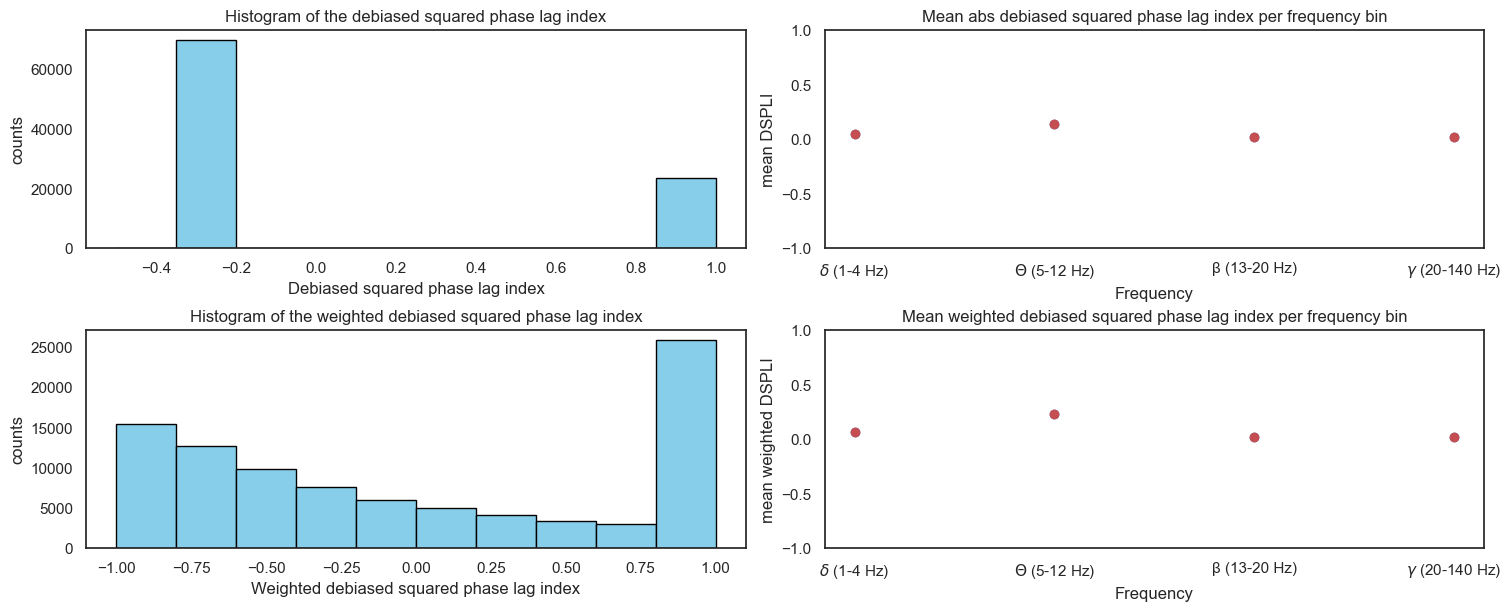

In [44]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 6), constrained_layout=True)

axes[0,0].hist(dspli_set, bins=10, color='skyblue', edgecolor='black')
axes[0,0].set_xlabel('Debiased squared phase lag index')
axes[0,0].set_ylabel('counts')
axes[0,0].set_title('Histogram of the debiased squared phase lag index')

axes[1,0].hist(wdspli_set, bins=10, color='skyblue', edgecolor='black')
axes[1,0].set_xlabel('Weighted debiased squared phase lag index')
axes[1,0].set_ylabel('counts')
axes[1,0].set_title('Histogram of the weighted debiased squared phase lag index')

mean = binned_statistic(frequency_set, dspli_set, bins=[1, 5, 13, 20, 140], statistic='mean')
stdev = binned_statistic(frequency_set, dspli_set, bins=[1, 5, 13, 20, 140], statistic='std')
n = len(dspli_set)

bin_edges = mean.bin_edges
bin_means = mean.statistic
bin_stdev = stdev.statistic
error = bin_stdev/(np.sqrt(n))

freq_middle = [3, 8, 16, 80]

axes[0,1].scatter(frequency_type, bin_means)
axes[0,1].errorbar(frequency_type, bin_means, yerr=error, fmt="o", color="r")
axes[0,1].set_ylim(-1,1)
#axes[2].set_xlim(0,140)
axes[0,1].set_ylabel('mean DSPLI')
axes[0,1].set_xlabel('Frequency')
axes[0,1].set_title('Mean abs debiased squared phase lag index per frequency bin')

mean2 = binned_statistic(frequency_set2, wdspli_set, bins=[1, 5, 13, 20, 140], statistic='mean')
stdev2 = binned_statistic(frequency_set2, wdspli_set, bins=[1, 5, 13, 20, 140], statistic='std')

bin_edges2 = mean2.bin_edges
bin_means2 = mean2.statistic
bin_stdev2 = stdev2.statistic
error2 = bin_stdev2/(np.sqrt(n))

axes[1,1].scatter(frequency_type, bin_means2)
axes[1,1].errorbar(frequency_type, bin_means2, yerr=error2, fmt="o", color="r")
axes[1,1].set_ylim(-1,1)
#axes[2].set_xlim(0,140)
axes[1,1].set_ylabel('mean weighted DSPLI')
axes[1,1].set_xlabel('Frequency')
axes[1,1].set_title('Mean weighted debiased squared phase lag index per frequency bin')

for i in range(len(bin_means)):
    print('mean dspli:', bin_means[i], '+/-', error[i])

for i in range(len(bin_means)):
    print('mean wdspli:', bin_means2[i], '+/-', error2[i])
#revbinnedstars, edges, _ = binned_statistic(rev_count, stars, 'mean', bins=10)
#revbin = edges[:-1]
mean_dspli_tonic = bin_means
mean_wdspli_tonic = bin_means2
SEM_dspli_tonic = error
SEM_wdspli_tonic = error2

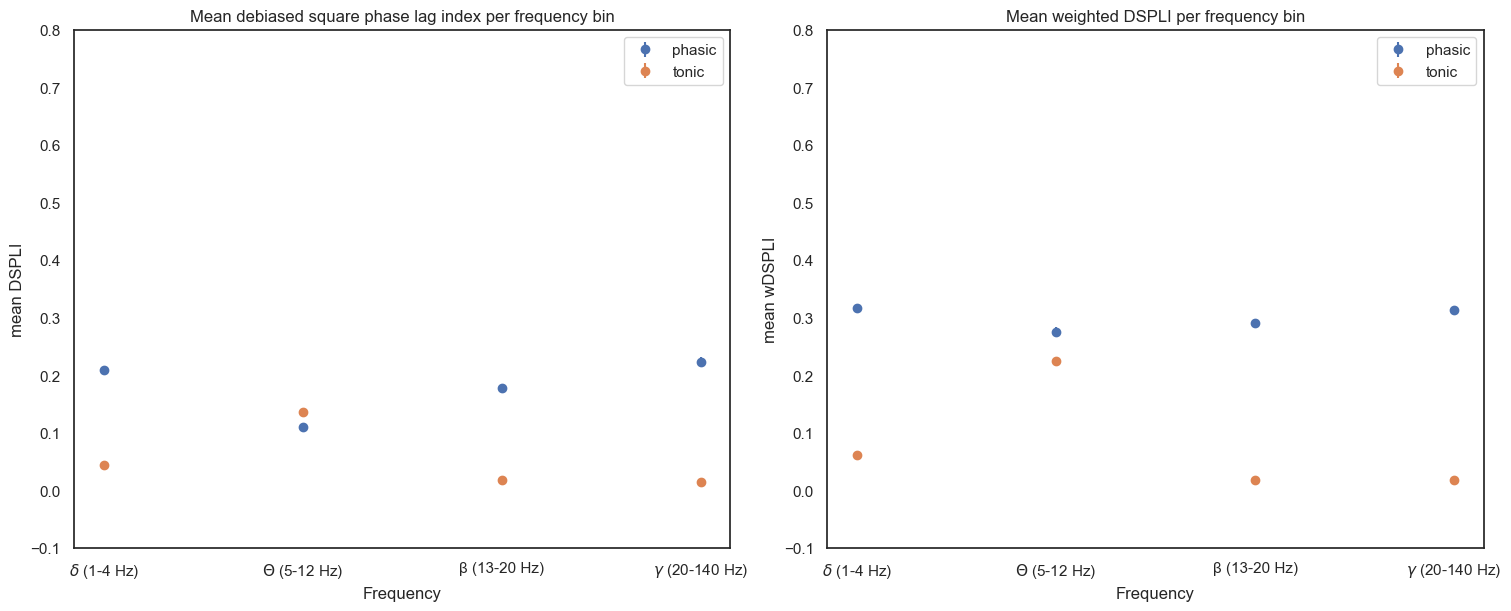

In [45]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6), constrained_layout=True)
axes[0].errorbar(frequency_type, mean_dspli_phasic, yerr=SEM_dspli_phasic, fmt="o", label='phasic')
axes[0].errorbar(frequency_type, mean_dspli_tonic, yerr=SEM_dspli_tonic, fmt="o", label='tonic')
axes[0].set_ylim(-0.1,0.8)
#axes[2].set_xlim(0,140)
axes[0].set_ylabel('mean DSPLI')
axes[0].set_xlabel('Frequency')
axes[0].set_title('Mean debiased square phase lag index per frequency bin')
axes[0].legend()

axes[1].errorbar(frequency_type, mean_wdspli_phasic, yerr=SEM_wdspli_phasic, fmt="o", label='phasic')
axes[1].errorbar(frequency_type, mean_wdspli_tonic, yerr=SEM_wdspli_tonic, fmt="o", label='tonic')
axes[1].set_ylim(-0.1,0.8)
#axes[2].set_xlim(0,140)
axes[1].set_ylabel('mean wDSPLI')
axes[1].set_xlabel('Frequency')
axes[1].set_title('Mean weighted DSPLI per frequency bin')
plt.legend()

## Pairwise phase consistency

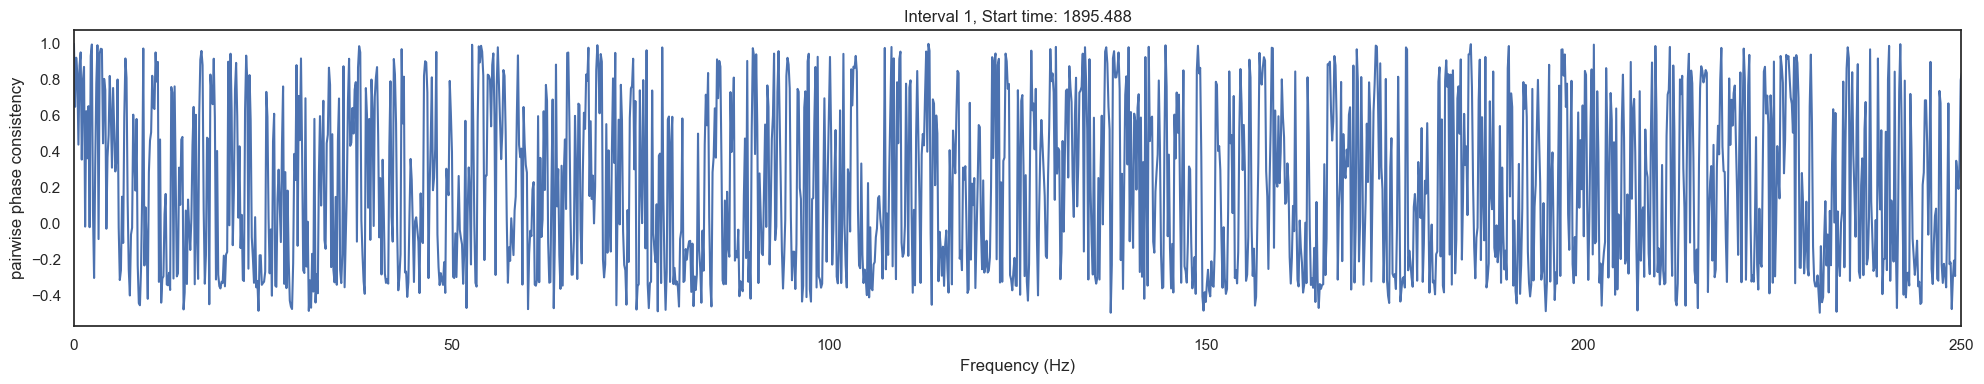

In [46]:
time_halfbandwidth_product = 2 #test value from example
sampling_frequency = 2500
frequency_set = []
ppc_set = []

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20, 4), constrained_layout=True)

for i in range(len(phasic_interval)):
    interval_low = find_nearest(t, phasic_interval[i,0])
    index_low = np.where(t == interval_low)[0]
    
    interval_high = find_nearest(t, phasic_interval[i,1])
    index_high = np.where(t == interval_high)[0]

    signal1 = (lfpHPC[index_low[0]:index_high[0]]).T
    signal1_padded = np.pad(signal1, pad_width = (highsize - len(signal1)), mode = 'constant', constant_values = 0)
    signal2 = (lfpPFC[index_low[0]:index_high[0]]).T
    signal2_padded = np.pad(signal2, pad_width = (highsize - len(signal2)), mode = 'constant', constant_values = 0)

    signal_tot = np.vstack((signal1_padded.T,signal2_padded.T)).T
    signal_tot.shape

    time = t[index_low[0]:index_high[0]]
    time_padded = np.pad(time, pad_width = (highsize - len(time)), mode = 'constant', constant_values = 0)

    multitaper = Multitaper(
        signal_tot,
        sampling_frequency=sampling_frequency,
        time_halfbandwidth_product=time_halfbandwidth_product,
        start_time=time_padded[0],
    )
    connectivity = Connectivity.from_multitaper(multitaper)
    
    frequency_set = np.append(frequency_set,connectivity.frequencies)
    ppc_set = np.append(ppc_set, connectivity.pairwise_phase_consistency()[..., 0, 1].squeeze())
    
    plt.plot(
        connectivity.frequencies, connectivity.pairwise_phase_consistency()[..., 0, 1].squeeze(),
    )
    #axes[i].set_xlim((0, multitaper.nyquist_frequency))
    plt.xlim((0, 250))
    plt.title(f"Interval {i+1}, Start time: {phasic_interval[i,0]}")
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('pairwise phase consistency')

fig.set_layout_engine(layout='tight')
fig.savefig("phasic_ppc_R1T2_CN.png")

mean ppc: 0.5346190075244205 +/- 0.004184103232626546
mean ppc: 0.17924007461734504 +/- 0.004937468417312805
mean ppc: 0.15742655984576162 +/- 0.005006220780159589
mean ppc: 0.20457272658373424 +/- 0.004986586618890529


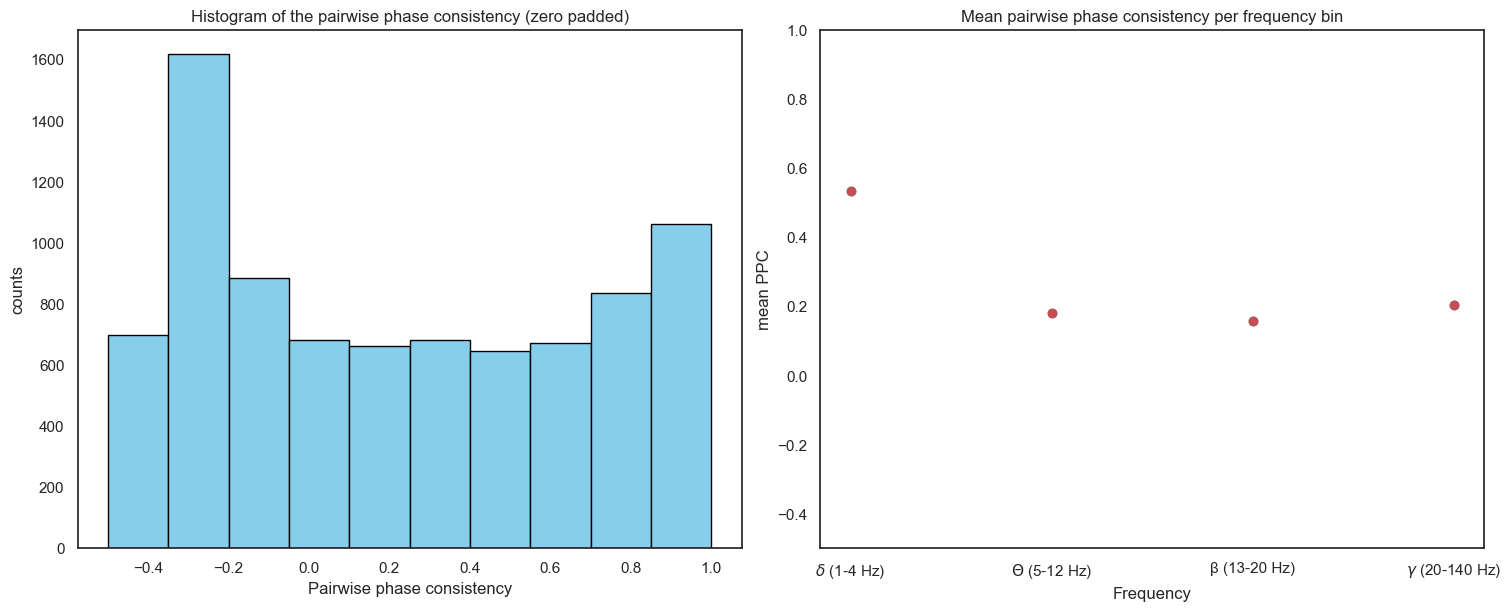

In [47]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6), constrained_layout=True)

axes[0].hist(ppc_set, bins=10, color='skyblue', edgecolor='black')
axes[0].set_xlabel('Pairwise phase consistency')
axes[0].set_ylabel('counts')
axes[0].set_title('Histogram of the pairwise phase consistency (zero padded)')


mean = binned_statistic(frequency_set, (ppc_set), bins=[1, 5, 13, 20, 140], statistic='mean')
stdev = binned_statistic(frequency_set, (ppc_set), bins=[1, 5, 13, 20, 140], statistic='std')
n = len(ppc_set)

bin_edges = mean.bin_edges
bin_means = mean.statistic
bin_stdev = stdev.statistic
error = bin_stdev/(np.sqrt(n))

freq_middle = [3, 8, 16, 80]

axes[1].scatter(frequency_type, bin_means)
axes[1].errorbar(frequency_type, bin_means, yerr=error, fmt="o", color="r")
axes[1].set_ylim(-0.5,1)
#axes[2].set_xlim(0,140)
axes[1].set_ylabel('mean PPC')
axes[1].set_xlabel('Frequency')
axes[1].set_title('Mean pairwise phase consistency per frequency bin')

for i in range(len(bin_means)):
    print('mean ppc:', bin_means[i], '+/-', error[i])
#revbinnedstars, edges, _ = binned_statistic(rev_count, stars, 'mean', bins=10)
#revbin = edges[:-1]

mean_ppc_phasic = bin_means
SEM_ppc_phasic = error

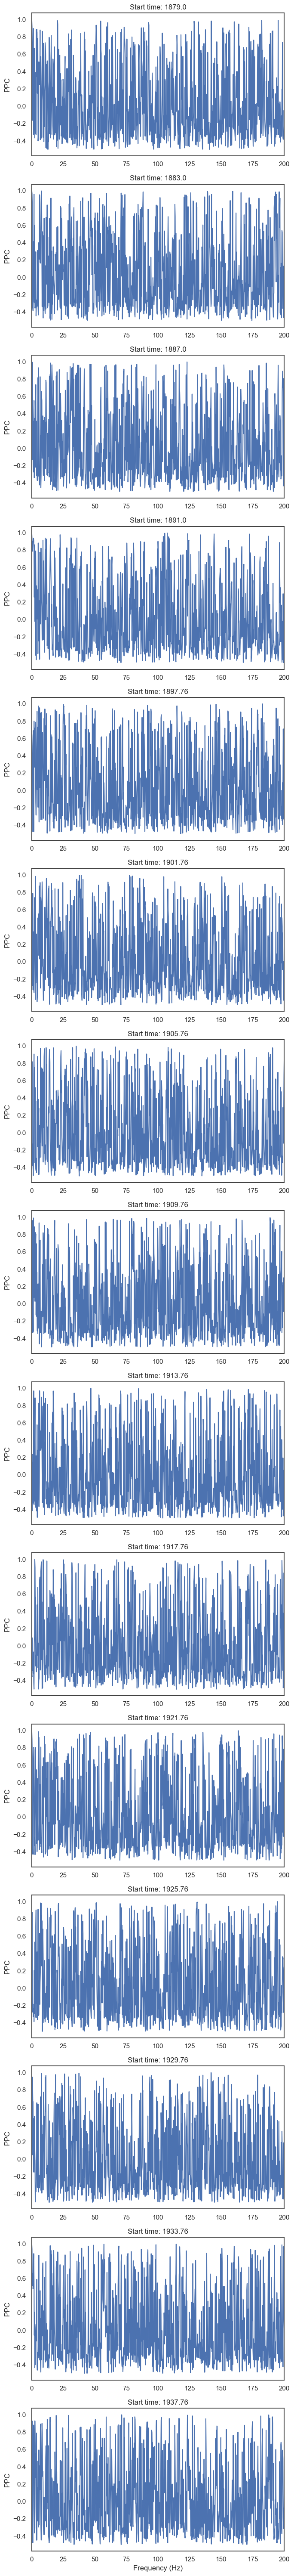

In [48]:
output_folder = "C:/Users/ejsev/Downloads/sleep scoring/outputs/Plots_OS_Basic"
time_halfbandwidth_product = 2 #test value from example
sampling_frequency = 2500
frequency_set = []
ppc_set = []

fig, axes = plt.subplots(nrows=len(tonic_time), ncols=1, figsize=(7, 60), constrained_layout=True)

for i in range(len(tonic_time)):
    tonic_interval_low = find_nearest(t, tonic_time[i,0])
    tonic_index_low = np.where(t == tonic_interval_low)[0]
    
    tonic_interval_high = find_nearest(t, tonic_time[i,1])
    tonic_index_high = np.where(t == tonic_interval_high)[0]

    signal1 = (lfpHPC[tonic_index_low[0]:tonic_index_high[0]]).T
    signal1_padded = np.pad(signal1, pad_width = (highsize - len(signal1)), mode = 'constant', constant_values = 0)
    signal2 = (lfpPFC[tonic_index_low[0]:tonic_index_high[0]]).T
    signal2_padded = np.pad(signal2, pad_width = (highsize - len(signal2)), mode = 'constant', constant_values = 0)

    signal_tot = np.vstack((signal1_padded.T,signal2_padded.T)).T
    signal_tot.shape

    time = t[index_low[0]:index_high[0]]
    time_padded = np.pad(time, pad_width = (highsize - len(time)), mode = 'constant', constant_values = 0)

    multitaper = Multitaper(
        signal_tot,
        sampling_frequency=sampling_frequency,
        time_halfbandwidth_product=time_halfbandwidth_product,
        start_time=time_padded[0],
    )
    connectivity = Connectivity.from_multitaper(multitaper)
    
    frequency_set = np.append(frequency_set,connectivity.frequencies)
    ppc_set = np.append(ppc_set, connectivity.pairwise_phase_consistency()[..., 0, 1].squeeze())
    
    axes[i].plot(
        connectivity.frequencies, connectivity.pairwise_phase_consistency()[..., 0, 1].squeeze(),
    )
    #axes[i].set_xlim((0, multitaper.nyquist_frequency))
    axes[i].set_xlim((0, 200))
    #axes[i].set_title(f"Interval {i+1}, real COH")
    axes[i].set_title(f"Start time: {tonic_time[i,0]}")
    #axes[i].set_xlabel('Frequency (Hz)')
    axes[i].set_ylabel('PPC')

axes[len(tonic_time)-1].set_xlabel('Frequency (Hz)')

fig.set_layout_engine(layout='tight')
fig.savefig("tonic_ppc_R1T2_CN.png")

mean ppc: 0.1270806384601453 +/- 0.0014629900578385445
mean ppc: 0.1437272783153094 +/- 0.0014744026331862704
mean ppc: 0.06226040177425681 +/- 0.001422710704052978
mean ppc: 0.01576232767505264 +/- 0.0013627564620862134


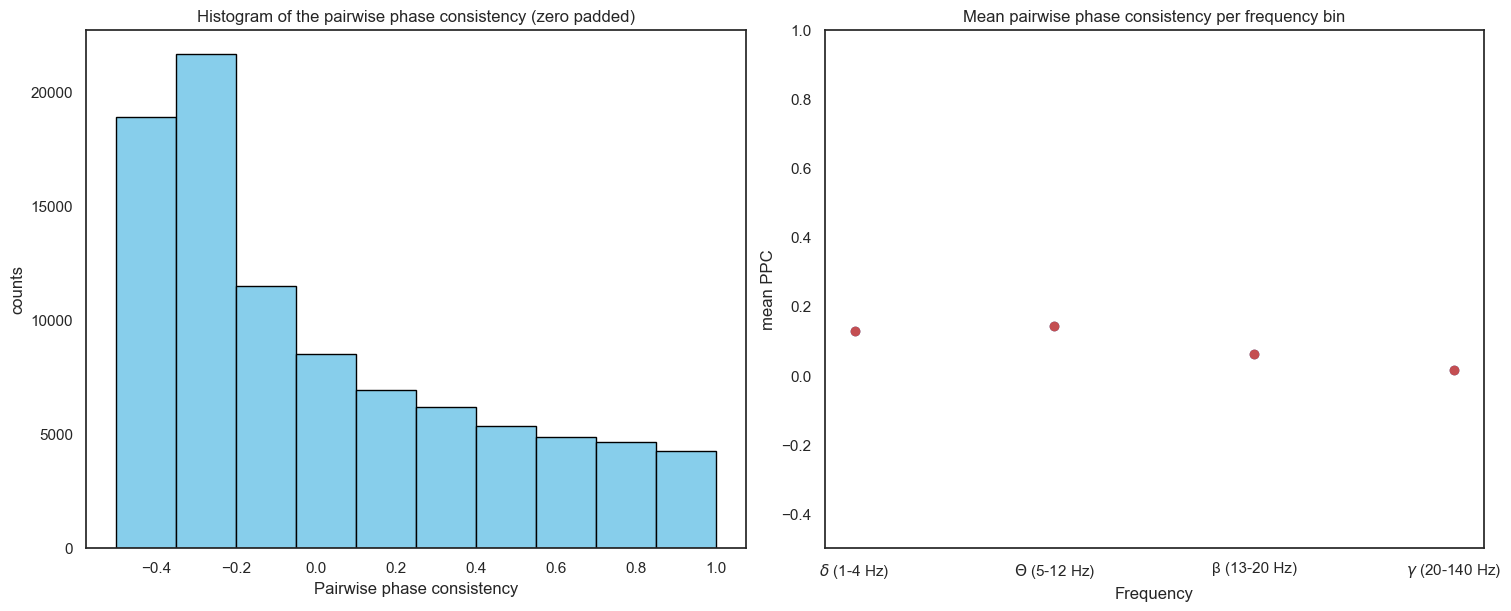

In [49]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6), constrained_layout=True)

axes[0].hist(ppc_set, bins=10, color='skyblue', edgecolor='black')
axes[0].set_xlabel('Pairwise phase consistency')
axes[0].set_ylabel('counts')
axes[0].set_title('Histogram of the pairwise phase consistency (zero padded)')


mean = binned_statistic(frequency_set, (ppc_set), bins=[1, 5, 13, 20, 140], statistic='mean')
stdev = binned_statistic(frequency_set, (ppc_set), bins=[1, 5, 13, 20, 140], statistic='std')
n = len(ppc_set)

bin_edges = mean.bin_edges
bin_means = mean.statistic
bin_stdev = stdev.statistic
error = bin_stdev/(np.sqrt(n))

freq_middle = [3, 8, 16, 80]

axes[1].scatter(frequency_type, bin_means)
axes[1].errorbar(frequency_type, bin_means, yerr=error, fmt="o", color="r")
axes[1].set_ylim(-0.5,1)
#axes[2].set_xlim(0,140)
axes[1].set_ylabel('mean PPC')
axes[1].set_xlabel('Frequency')
axes[1].set_title('Mean pairwise phase consistency per frequency bin')

for i in range(len(bin_means)):
    print('mean ppc:', bin_means[i], '+/-', error[i])
#revbinnedstars, edges, _ = binned_statistic(rev_count, stars, 'mean', bins=10)
#revbin = edges[:-1]
mean_ppc_tonic = bin_means
SEM_ppc_tonic = error

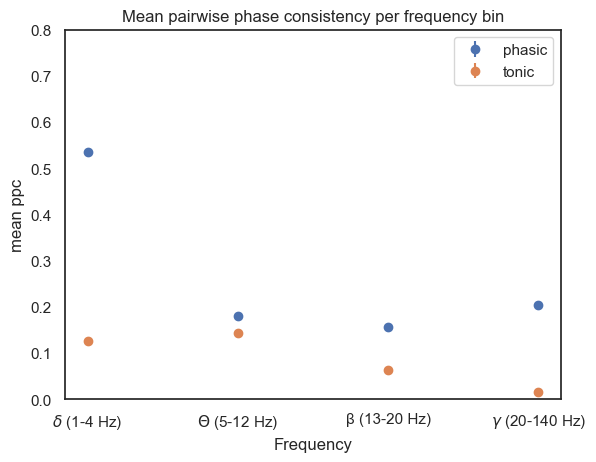

In [50]:
plt.errorbar(frequency_type, mean_ppc_phasic, yerr=SEM_ppc_phasic, fmt="o", label='phasic')
plt.errorbar(frequency_type, mean_ppc_tonic, yerr=SEM_ppc_tonic, fmt="o", label='tonic')
plt.ylim(0,0.8)
plt.ylabel('mean ppc')
plt.xlabel('Frequency')
plt.title('Mean pairwise phase consistency per frequency bin')
plt.legend()

## Table

In [51]:
mean_coh = np.hstack((mean_coh_phasic, mean_coh_tonic))
mean_icoh = np.hstack((mean_icoh_phasic, mean_icoh_tonic))
mean_pli = np.hstack((mean_pli_phasic, mean_pli_tonic))
mean_wpli = np.hstack((mean_wpli_phasic, mean_wpli_tonic))
mean_dspli = np.hstack((mean_dspli_phasic, mean_dspli_tonic))
mean_wdspli = np.hstack((mean_wdspli_phasic, mean_wdspli_tonic))
mean_ppc = np.hstack((mean_ppc_phasic, mean_ppc_tonic))

SEM_coh = np.hstack((SEM_coh_phasic, SEM_coh_tonic))
SEM_icoh = np.hstack((SEM_icoh_phasic, SEM_icoh_tonic))
SEM_pli = np.hstack((SEM_pli_phasic, SEM_pli_tonic))
SEM_wpli = np.hstack((SEM_wpli_phasic, SEM_wpli_tonic))
sem_dspli = np.hstack((SEM_dspli_phasic, SEM_dspli_tonic))
sem_wdspli = np.hstack((SEM_wdspli_phasic, SEM_wdspli_tonic))
SEM_ppc = np.hstack((SEM_ppc_phasic, SEM_ppc_tonic))

In [52]:
rows = []
for i in range(8):
    rows.append({
                    'COH': mean_coh[i],
                    'SE COH': SEM_coh[i],
                    'iCOH': mean_icoh[i],
                    'SE iCOH': SEM_icoh[i],
                    'PLI': mean_pli[i],
                    'SE PLI': SEM_pli[i],
                    'wPLI': mean_wpli[i],
                    'SE wPLI': SEM_wpli[i],
                    'DSPLI': mean_dspli[i],
                    'SE DSPLI': sem_dspli[i],
                    'wDSPLI': mean_wdspli[i],
                    'SE wDSPLI': sem_wdspli[i],
                    'PPC': mean_ppc[i],
                    'SE PPC': SEM_ppc[i]
                })
df = pd.DataFrame(rows, index = ["phasic delta", "phasic theta", "phasic theta-gamma", "phasic gamma", "tonic delta", "tonic theta", "tonic theta-gamma", "tonic gamma"])
df.to_csv('C:/Users/ejsev/Downloads/sleep scoring/table_connectivity_R1T2_CN.csv', index=True)
df

COH    SE COH      iCOH   SE iCOH       PLI  \
phasic delta        0.576654  0.003173  0.306047  0.002132 -0.037037   
phasic theta        0.304095  0.002672  0.388814  0.002962  0.382716   
phasic theta-gamma  0.387017  0.003156  0.504669  0.002989  0.205674   
phasic gamma        0.346587  0.002933  0.462480  0.002697  0.062063   
tonic delta         0.246519  0.000797  0.347209  0.000755  0.050505   
tonic theta         0.256916  0.000779  0.426659  0.000819  0.267227   
tonic theta-gamma   0.207907  0.000706  0.342784  0.000774  0.025048   
tonic gamma         0.181216  0.000678  0.350293  0.000758 -0.011010   

                      SE PLI      wPLI   SE wPLI     DSPLI  SE DSPLI  \
phasic delta        0.007478 -0.095197  0.008719  0.209877  0.007132   
phasic theta        0.005561  0.540447  0.006437  0.111111  0.006842   
phasic theta-gamma  0.006964  0.359650  0.008081  0.177305  0.007056   
phasic gamma        0.007533  0.074107  0.009026  0.224003  0.007159   
tonic delta         0.001969  0.078667  0.002382  0.043771  0.001970   
tonic theta         0.001951  0.368613  0.002303  0.137255  0.002091   
tonic theta-gamma   0.001928  0.020674  0.002338  0.018626  0.001928   
tonic gamma         0.001923 -0.020988  0.002351  0.015564  0.001923   

                      wDSPLI  SE wDSPLI       PPC    SE PPC  
phasic delta        0.316749   0.007624  0.534619  0.004184  
phasic theta        0.275927   0.008308  0.179240  0.004937  
phasic theta-gamma  0.290597   0.008019  0.157427  0.005006  
phasic gamma        0.313057   0.007908  0.204573  0.004987  
tonic delta         0.062212   0.002445  0.127081  0.001463  
tonic theta         0.224912   0.002451  0.143727  0.001474  
tonic theta-gamma   0.018159   0.002434  0.062260  0.001423  
tonic gamma         0.018659   0.002436  0.015762  0.001363